<div style="
    text-align: center;
    font-size: 48px;
    font-weight: bold;
    color: #000000;
    text-shadow: 2px 2px 5px #888888;
    margin-top: 20px;
    margin-bottom: 20px;
    font-family: Arial, sans-serif;
    border-bottom: 3px solid #000000;">
    LOS ANGELES CRIME 
</div>

<div style="text-align: center;">
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcThUsuZoIYQ1smOzyvV96baiOBTr7dI59zXCQ&s" alt="Alt text" width="700">
</div>



# Group number 13
## Presenting by:
###  Baral Levi  
### Ella Admoni
### Tomer Meirovich 

## links:

####  Kaggle: https://www.kaggle.com/datasets/asaniczka/crimes-in-los-angeles-2020-2023
####  GitHub : https://github.com/BareLevi/Project_Ella_Tomer_Barel/blob/main/Ella_Tomer_bBarel_project_updated.ipynb




### Load the data into the program

In [225]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import sys
import traceback

def merge_csv_files(file_paths):
    
    dataframes = []

    
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        dataframes.append(df)


    merged_df = pd.concat(dataframes, ignore_index=True)
    
    return merged_df


file_paths = [
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_1.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_2.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_3.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_4.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_5.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_6.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_7.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_8.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_9.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_10.csv'
]

df = merge_csv_files(file_paths)


##### Suppress Warnings

In [226]:
warnings.filterwarnings('ignore')
sys.tracebacklimit = 0

### 1.  Wrangling data

In [227]:
df.dtypes

division_number          int64
date_reported           object
date_occurred           object
area                     int64
area_name               object
reporting_district       int64
part                     int64
crime_code               int64
crime_description       object
modus_operandi          object
victim_age               int64
victim_sex              object
victim_descent          object
premise_code           float64
premise_description     object
weapon_code            float64
weapon_description      object
status                  object
status_description      object
crime_code_1           float64
crime_code_2           float64
crime_code_3           float64
crime_code_4           float64
location                object
cross_street            object
latitude               float64
longitude              float64
dtype: object

#### 1.1 Noisy data
- Boxplot all numberic columns to check for exceptions


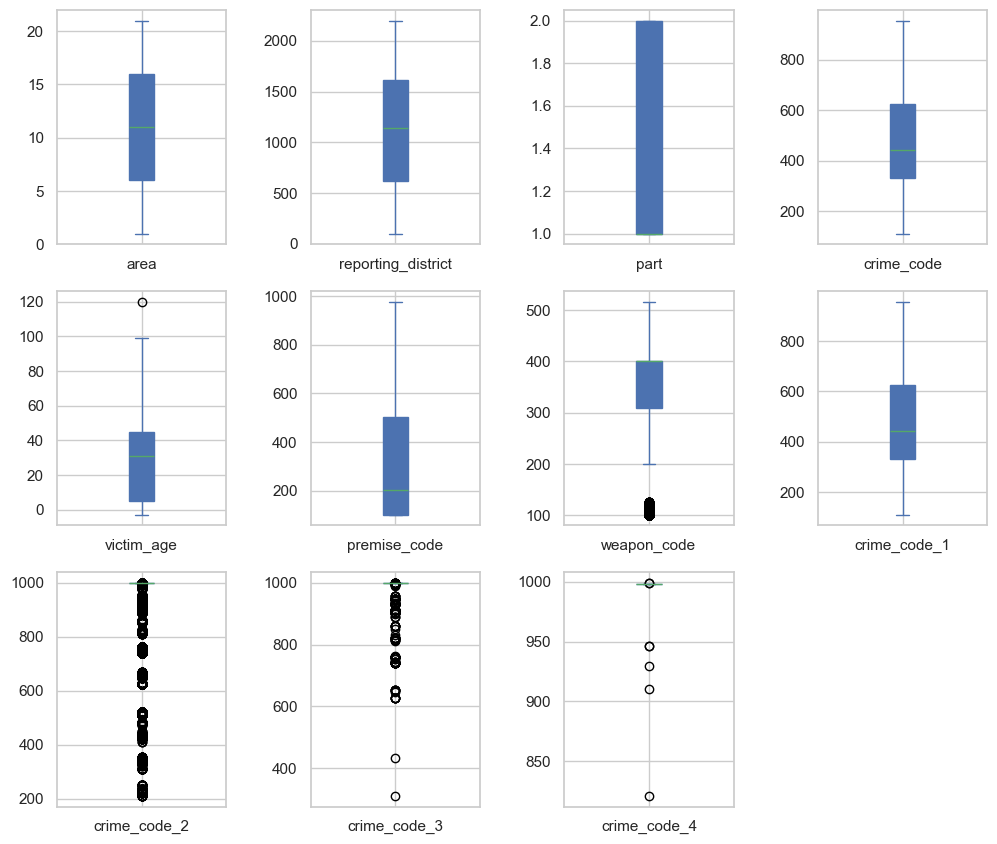

In [228]:
df_to_plot = df.drop(columns=['latitude', 'longitude', 'division_number'])
df_to_plot = df_to_plot.select_dtypes(include=np.number)
df_to_plot.plot(subplots=True, layout=(4, 4), kind='box', figsize=(12, 14), patch_artist=True)
plt.subplots_adjust(wspace=0.5)
plt.show()

ניתן לראות שלמעט העמודות קוד הפשע 2-4, אפשר מתארות יש נו קוד פשע נוסף שקשור לכן הגיוני שיש ערכים חסרים. גם בקוד הנשק הגיוני שיהיו חריגים מכייון שלא כל כל פשע התבצע בעזרת נשק.ניתן לראות שיש הרבה נתונים סביב האפס בעמודות הגילאים נבדוק זאת לעומק

#### 1.2  Checking the column victim_age

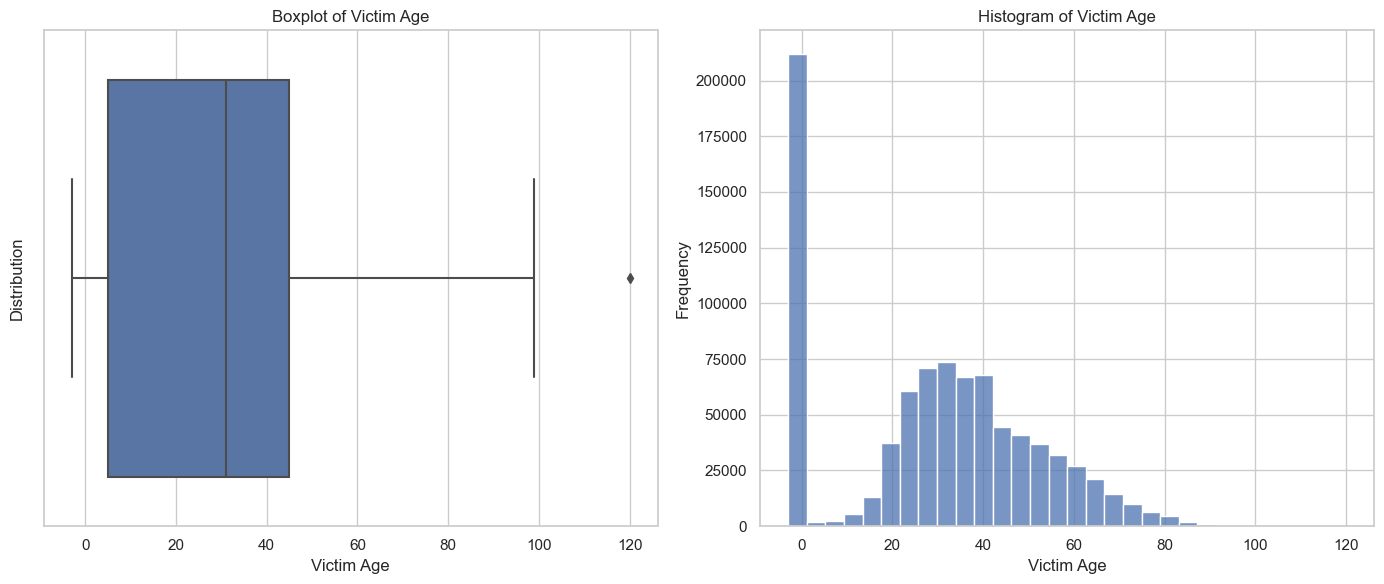

In [229]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(ax=axes[0], x='victim_age', data=df)
axes[0].set_title('Boxplot of Victim Age')
axes[0].set_xlabel('Victim Age')
axes[0].set_ylabel('Distribution')


sns.histplot(ax=axes[1], x='victim_age', data=df, kde=False, bins=30)
axes[1].set_title('Histogram of Victim Age')
axes[1].set_xlabel('Victim Age')
axes[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

ניתן לראות שבאופן מסויים כנראה במקום לעשות ערכים חסרים הזינו 0

In [230]:
filtered_data = df[df['victim_age'] == 0]
crime_description_counts = filtered_data['crime_description'].value_counts()

crime_description_counts.head(20)


crime_description
VEHICLE - STOLEN                                            91191
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             18467
BURGLARY                                                    16270
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                    13813
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     12756
ROBBERY                                                      5782
THEFT PLAIN - PETTY ($950 & UNDER)                           5683
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     5503
TRESPASSING                                                  4935
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                     4657
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)                   2858
SHOPLIFTING-GRAND THEFT ($950.01 & OVER)                     2773
OTHER MISCELLANEOUS CRIME                                    2235
DISCHARGE FIREARMS/SHOTS FIRED                               1938
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT            

ניתן לראות שיש המון ערכים ששווים ל0 בעמודת הגילאים לא נהמר להורידם מכייון שהם עדייין פשעים שקרו למעט זה נראה שהנותנים תקינים

### 2.  Creating relevant columns

##### 2.1 Convert columns to data time

In [231]:
df['date_occurred'] = pd.to_datetime(df['date_occurred'])
df['date_reported'] = pd.to_datetime(df['date_reported'])


##### 2.2 Creating a column by seasons

In [232]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'
df['seasons_occurred'] = df['date_occurred'].dt.month.apply(get_season)

##### 2.3 Creating a column by during the day

In [233]:
def categorize_time(datetime):
    hour = datetime.hour
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Noon'
    elif 16 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'
df['day_time'] = df['date_occurred'].apply(categorize_time)

##### 2.4 Creating columns by hour,year and day name

In [234]:
df['hour_occurred'] = df['date_occurred'].dt.hour
df['day_of_week'] = df['date_occurred'].dt.day_name()
df['year_occurred'] = df['date_occurred'].dt.year

##### 2.5 Creating column by age description

In [235]:
def age_category(age):
        age = int(age)
        if age > 0 and age < 10:
            return "child"
        elif age >= 10 and age < 18:
            return "teenager"
        elif age >= 18 and age < 60:
            return "adult"
        elif age >= 60:
            return "old"
        else:    
            return "unknown"


df["age_description"] = df["victim_age"].apply(age_category)

##### 2.6 Creating a column to classify the type of weapon if any

In [236]:
def classify_weapon(weapon_description):
    firearm_keywords = ['PISTOL', 'REVOLVER', 'RIFLE', 'SHOTGUN', 'FIREARM', 'GUN', 'ASSAULT WEAPON', 'MAC', 'UZI', 'HECKLER & KOCH', 'EXPLOXIVE DEVICE', 'AUTOMATIC WEAPON', 'SEMI-AUTOMATIC', 'STARTER PISTOL', 'M1-1', 'M-14', 'BOMB', 'BOMB THREAT']
    sharp_keywords = ['KNIFE', 'SWORD', 'BLADE', 'SCISSORS', 'AXE', 'SCREWDRIVER', 'DIRK', 'DAGGER', 'CLEAVER', 'RAZOR', 'ICE PICK', 'BOWIE KNIFE', 'STRAIGHT RAZOR', 'OTHER CUTTING INSTRUMENT', 'UNKNOWN TYPE CUTTING INSTRUMENT']
    vehicle_keywords = ['VEHICLE']
    fire_bomb_keywords = ['FIRE', 'EXPLOXIVE DEVICE']
    threat_keywords = ['VERBAL THREAT', 'DEMAND NOTE', 'BOMB THREAT']
    improvised_keywords = ['ROCK', 'THROWN OBJECT', 'BLUNT INSTRUMENT', 'BOTTLE', 'CLUB', 'BAT', 'PIPE', 'STICK', 'HAMMER', 'GLASS', 'BRICK', 'BOARD', 'BELT', 'CHAIN', 'MARTIAL ARTS', 'CONCRETE BLOCK', 'SIMULATED GUN', 'MACE', 'PEPPER SPRAY', 'TOY GUN', 'SYRINGE', 'LIQUOR', 'DRUGS', 'FIXED OBJECT', 'BLACKJACK', 'RELIC FIREARM', 'AIR PISTOL', 'CAUSTIC CHEMICAL', 'POISON', 'BRASS KNUCKLES', 'TIRE IRON', 'DOG/ANIMAL (SIC ANIMAL ON)', 'SCALDING LIQUID', 'ROPE/LIGATURE', 'BOW AND ARROW']
    physical_keywords = ['STRONG-ARM', 'HANDS', 'FIST', 'FEET', 'BODILY FORCE', 'PHYSICAL PRESENCE']
    
    if pd.isna(weapon_description):
         if pd.isna(weapon_description):
            return np.nan
    
    if 'UNKNOWN WEAPON' in weapon_description or 'OTHER WEAPON' in weapon_description:
        return 'Unknown Weapon'
    if any(keyword in weapon_description for keyword in firearm_keywords):
        return 'firearm'
    elif any(keyword in weapon_description for keyword in sharp_keywords):
        return 'sharp weapon'
    elif any(keyword in weapon_description for keyword in vehicle_keywords):
        return 'vehicles'
    elif any(keyword in weapon_description for keyword in fire_bomb_keywords):
        return 'fire and bombs'
    elif any(keyword in weapon_description for keyword in threat_keywords):
        return 'threats'
    elif any(keyword in weapon_description for keyword in improvised_keywords):
        return 'improvised weapon'
    elif any(keyword in weapon_description for keyword in physical_keywords):
        return 'Physical strength'
    else:
        return 'OTHER'


df['weapon_category'] = df['weapon_description'].apply(classify_weapon)

In [237]:
df.dtypes

division_number                 int64
date_reported          datetime64[ns]
date_occurred          datetime64[ns]
area                            int64
area_name                      object
reporting_district              int64
part                            int64
crime_code                      int64
crime_description              object
modus_operandi                 object
victim_age                      int64
victim_sex                     object
victim_descent                 object
premise_code                  float64
premise_description            object
weapon_code                   float64
weapon_description             object
status                         object
status_description             object
crime_code_1                  float64
crime_code_2                  float64
crime_code_3                  float64
crime_code_4                  float64
location                       object
cross_street                   object
latitude                      float64
longitude   

### 3. Search for correlations

##### 3.1 Mapping relevant columns

In [297]:
status_mapping = {'AO': 1, 'IC': 2, 'AA': 3, 'JA': 4, 'JO': 5, 'CC': 6}
victim_descent_mapping = {'B': 1, 'H': 2, 'X': 3, 'W': 4, 'A': 5, 'O': 6, 'C': 7, 'F': 8, 'K': 9, 'I': 10, 'V': 11, 'Z': 12, 'J': 13, 'P': 14, 'G': 15, 'U': 16, 'D': 17, 'S': 18, 'L': 19}
day_of_week_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7}
day_time_mapping = {'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4}
seasons_occurred_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
age_description_mapping = {'adult': 1, 'unknown': 2, 'old': 3, 'teenager': 4, 'child': 5}


df['status_numeric'] = df['status'].map(status_mapping)
df['victim_descent_numeric'] = df['victim_descent'].map(victim_descent_mapping)
df['day_of_week_numeric'] = df['day_of_week'].map(day_of_week_mapping)
df['day_time_numeric'] = df['day_time'].map(day_time_mapping)
df['seasons_occurred_numeric'] = df['seasons_occurred'].map(seasons_occurred_mapping)
df['age_description_numeric'] = df['age_description'].map(age_description_mapping)

##### 3.2 Correlations heatmap

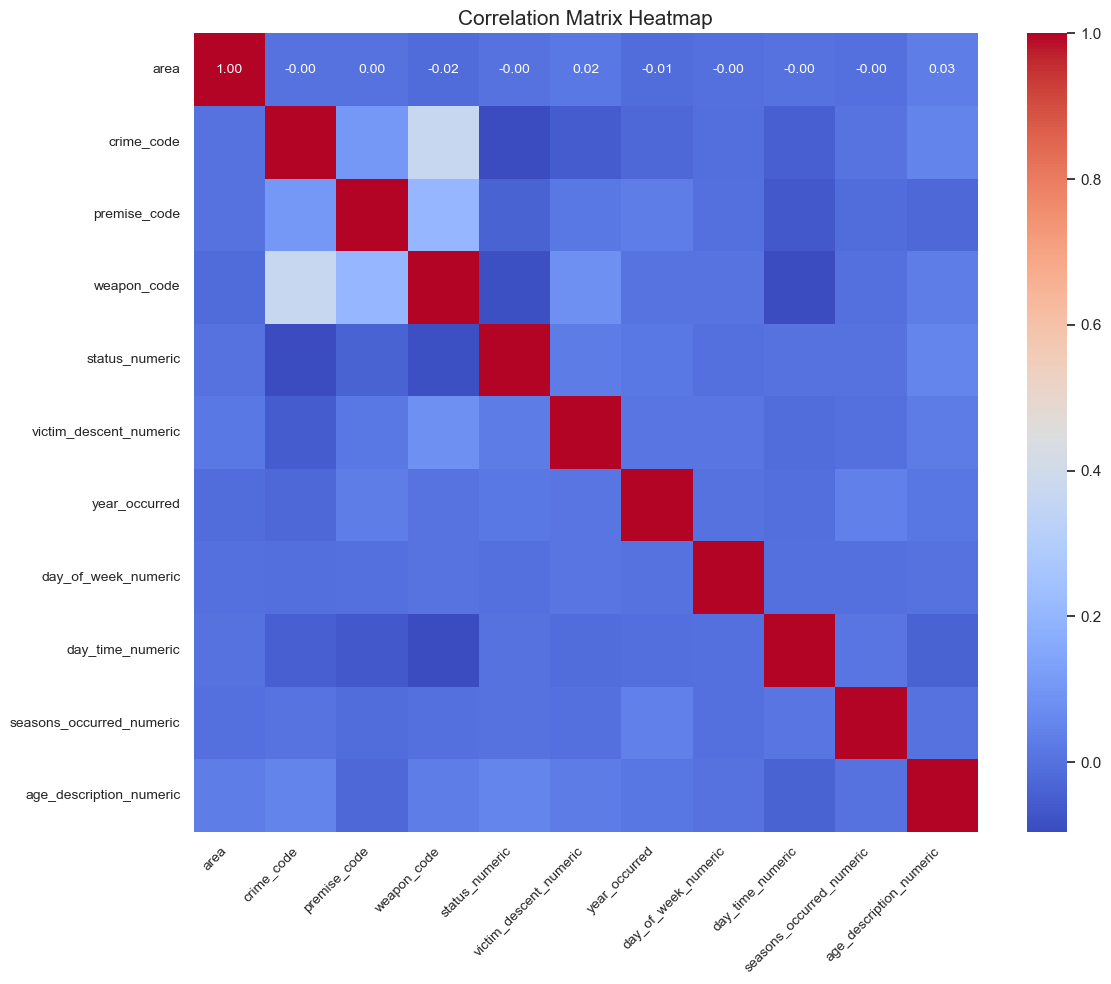

In [299]:
features = [
    'area', 'crime_code', 'premise_code', 'weapon_code', 'status_numeric', 
    'victim_descent_numeric', 'year_occurred', 'day_of_week_numeric', 
    'day_time_numeric', 'seasons_occurred_numeric',
    'age_description_numeric'
]


correlation_matrix = df[features].corr()

# יצירת הדמות וההיטמפ
plt.figure(figsize=(12, 10))  # הגדלת גודל הדמות
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})  # הגדלת הפונט של המספרים

# כיוון הכותרים של ציר ה-X
plt.xticks(rotation=45, ha="right", fontsize=10)  # הגדלת הפונט של הכותרים בציר ה-X
plt.yticks(fontsize=10)  # הגדלת הפונט של הכותרים בציר ה-Y

# כותרת
plt.title('Correlation Matrix Heatmap', fontsize=15)  # הגדלת הפונט של הכותרת

# הצגת הדמות
plt.tight_layout()  # סידור הדמות
plt.show()


### Physical Violence Against Children and Adolescents

In [240]:
relevant_crimes = [
    'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
    'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',"BATTERY - SIMPLE ASSAULT","ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAUL",
    "OTHER ASSAULT"
    
    
]

Under_age_18_df = df[(df["age_description"] == "child") | (df["age_description"] == "teenager")]
Under_age_18_df = Under_age_18_df[Under_age_18_df['crime_description'].isin(relevant_crimes)]









In [241]:
child_df = Under_age_18_df[Under_age_18_df["age_description"] == "child"]
child_df_place_count = child_df['premise_description'].value_counts().reset_index()
child_df_place_count.columns = ["place_description", "amount"]



teenager_df = Under_age_18_df[Under_age_18_df["age_description"] == "teenager"]
teenager_df_place_count = teenager_df['premise_description'].value_counts().reset_index()
teenager_df_place_count.columns = ["place_description", "amount"]




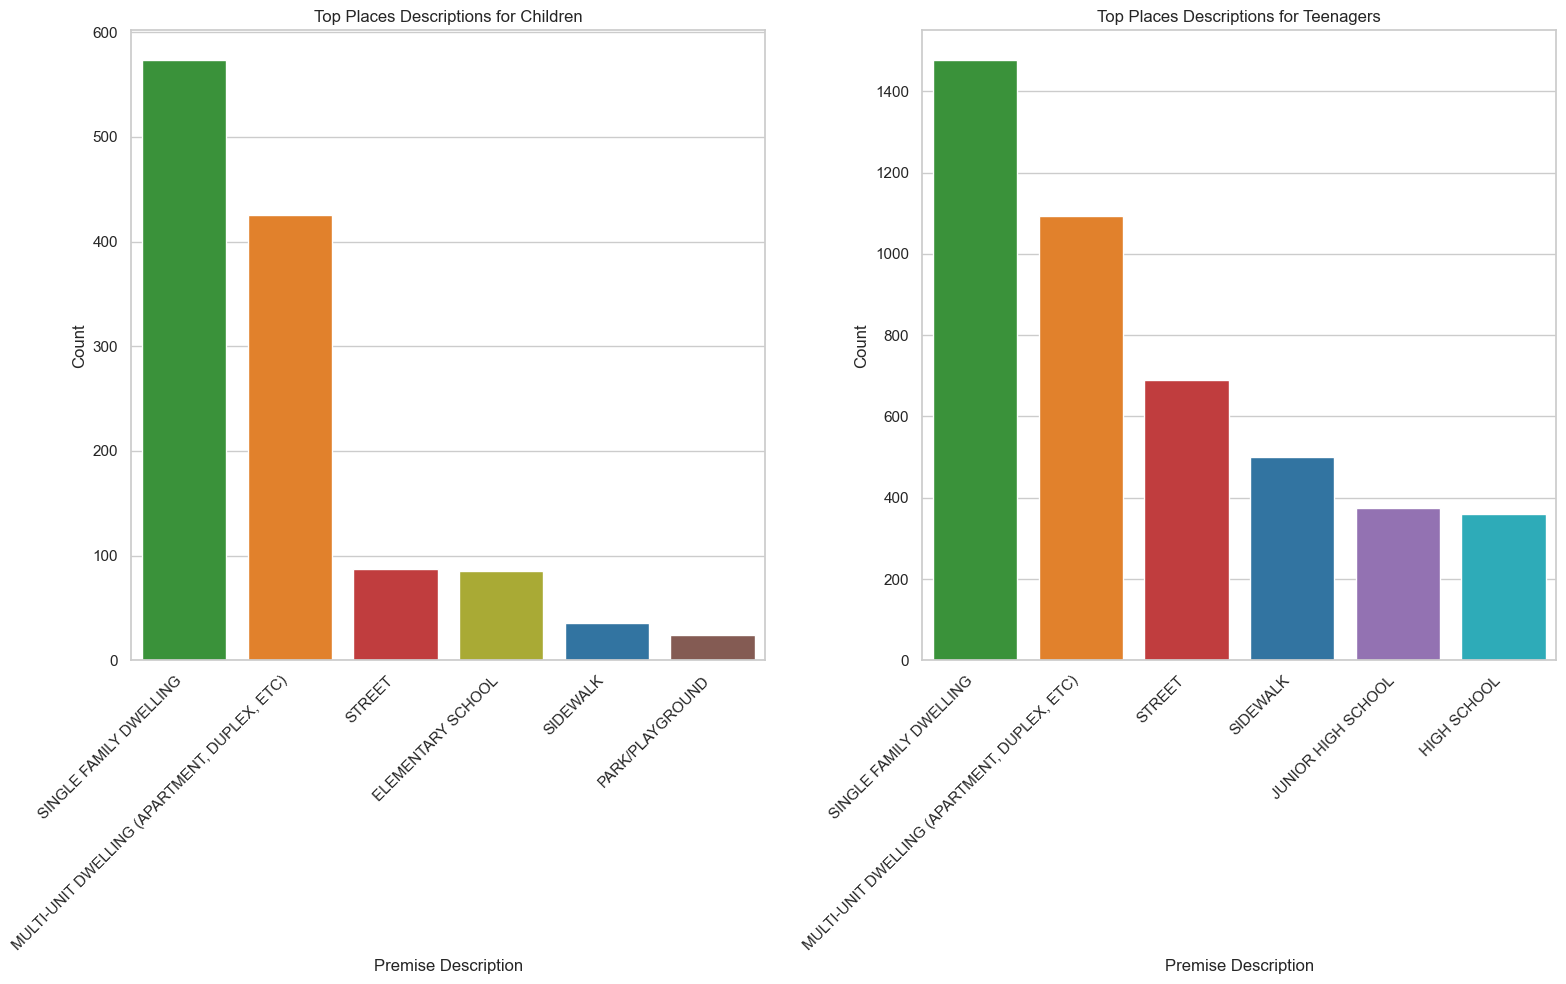

In [242]:
top_child_places = child_df_place_count.head(6)
top_teenager_places = teenager_df_place_count.head(6)


common_places = set(top_child_places['place_description']).intersection(set(top_teenager_places['place_description']))


custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#17becf', '#bcbd22']  # כחול, כתום, ירוק, אדום, סגול, חום, טורקיז, צהוב ירקרק
unique_places = list(set(top_child_places['place_description']).union(set(top_teenager_places['place_description'])))
color_mapping = {place: custom_palette[i % len(custom_palette)] for i, place in enumerate(unique_places)}


plt.figure(figsize=(16, 10))


plt.subplot(1, 2, 1)
sns.barplot(data=top_child_places, x='place_description', y='amount', palette=[color_mapping[place] for place in top_child_places['place_description']])
plt.xticks(rotation=45, ha="right")
plt.title('Top Places Descriptions for Children')
plt.xlabel('Premise Description')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.barplot(data=top_teenager_places, x='place_description', y='amount', palette=[color_mapping[place] for place in top_teenager_places['place_description']])
plt.xticks(rotation=45, ha="right")
plt.title('Top Places Descriptions for Teenagers')
plt.xlabel('Premise Description')
plt.ylabel('Count')


plt.tight_layout()
plt.show()

### One can discern that when it comes to acts of violence and sexual offenses, residential areas appear in the first two age groups

### Creating a new column to help us understand whether the incidents occurred in residential areas, schools, or elsewhere

In [243]:
residential_areas = [
    'SINGLE FAMILY DWELLING', 'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)',
    'GROUP HOME', 'OTHER RESIDENCE', 'YARD (RESIDENTIAL/BUSINESS)',
    'CONDOMINIUM/TOWNHOUSE', 'MOBILE HOME/TRAILERS/CONSTRUCTION TRAILERS/RV\'S/MOTORHOME',
    'FOSTER HOME BOYS OR GIRLS*', 'PROJECT/TENEMENT/PUBLIC HOUSING', 'PORCH, RESIDENTIAL',
    'TRANSIENT ENCAMPMENT', 'SINGLE RESIDENCE OCCUPANCY (SRO\'S) LOCATIONS'
]

schools = [
    'HIGH SCHOOL', 'JUNIOR HIGH SCHOOL', 'ELEMENTARY SCHOOL',
    'SPECIALTY SCHOOL/OTHER', 'PRIVATE SCHOOL/PRESCHOOL', 'DAY CARE/CHILDREN*',
    'BUS, SCHOOL, CHURCH', 'COLLEGE/JUNIOR COLLEGE/UNIVERSITY', 'DAY CARE/ADULTS*',
    'TRADE SCHOOL (MEDICAL-TECHNICAL-BUSINESS)*', 'FRAT HOUSE/SORORITY/DORMITORY'
]




def categorize_premise(premise):
    if premise in residential_areas:
        return 'Residential Areas'
    elif premise in schools:
        return 'Schools'
    else:
        return 'Non-Residential and Non-Schools'

Under_age_18_df['where_did_it_happen'] = Under_age_18_df['premise_description'].apply(categorize_premise)
### בנינו פונקציה שבודקת האם המקרה קרה מתחם מגורים למשל סוגרי דירות למינהם 

In [244]:
Under_age_18_df_value_counts = Under_age_18_df['where_did_it_happen'].value_counts().reset_index()
Under_age_18_df_value_counts.columns = ['where_did_it_happen', 'count']
Under_age_18_df_value_counts

,where_did_it_happen,count
0,Residential Areas,3806
1,Non-Residential and Non-Schools,2429
2,Schools,974


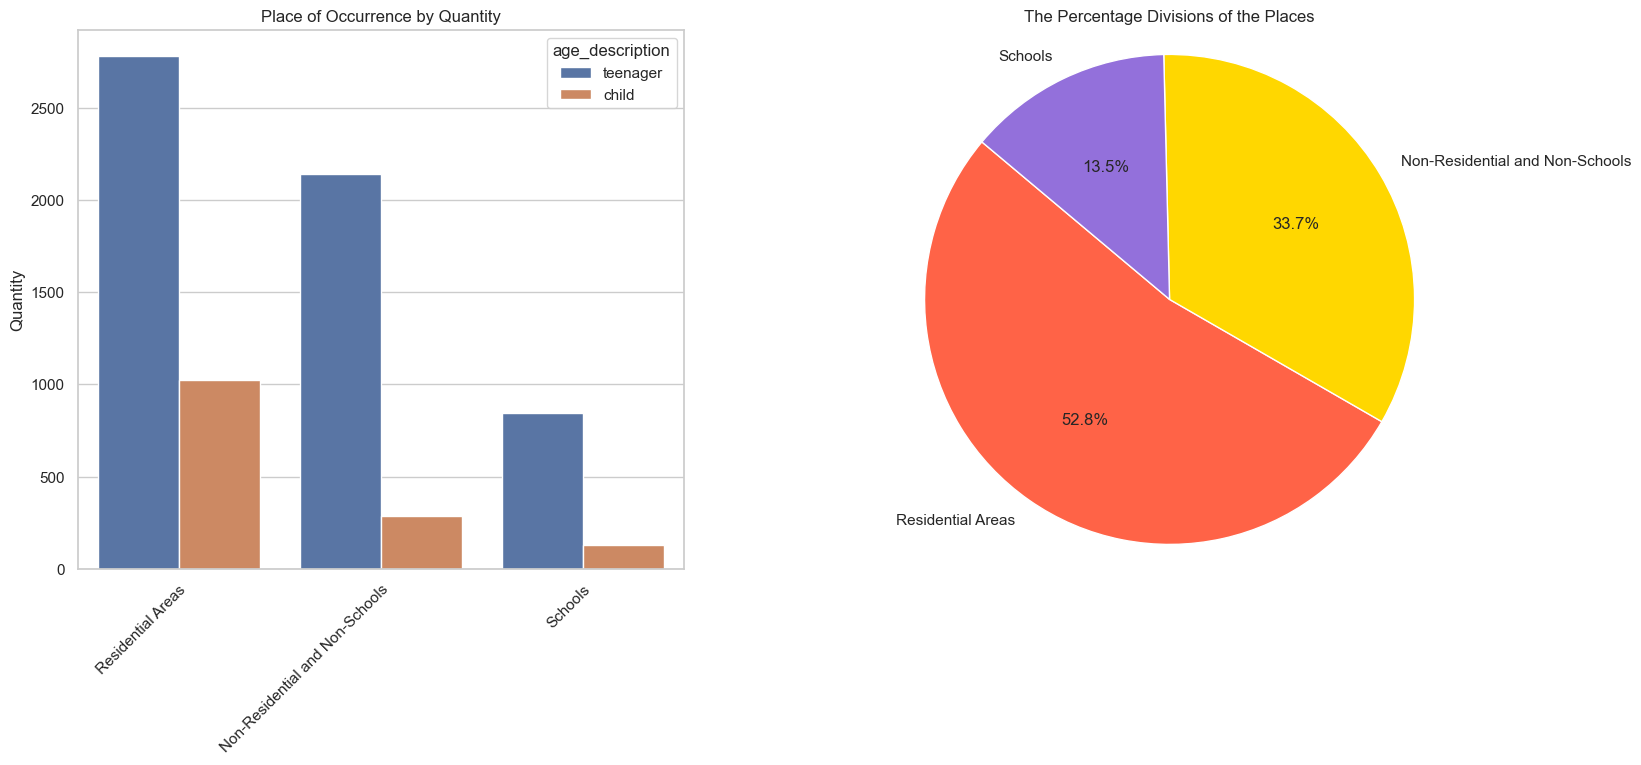

In [245]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))


sns.countplot(data=Under_age_18_df[Under_age_18_df['where_did_it_happen'] != 'Unknown'], hue='age_description', x='where_did_it_happen', order=Under_age_18_df_value_counts['where_did_it_happen'], ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax[0].set_title('Place of Occurrence by Quantity')
ax[0].set_xlabel('')
ax[0].set_ylabel('Quantity')


pie_data = Under_age_18_df['where_did_it_happen'].value_counts().reset_index()
pie_data.columns = ['where_did_it_happen', 'count']
colors = ['#FF6347', '#FFD700', '#9370DB']  # Matte red, yellow, and purple
ax[1].pie(pie_data['count'], labels=pie_data['where_did_it_happen'], autopct='%1.1f%%', startangle=140, colors=colors)
ax[1].set_title('The Percentage Divisions of the Places')
ax[1].axis('equal')


plt.subplots_adjust(wspace=0.3)
plt.show()

נתונים מדאיגים מצביעים על כך שגם עבור ילדים וגם עבור בני נוער המקומות שבהם הם הכי חשופים לאלימות הם דווקא בבית

In [246]:
all_population_df = df[df['crime_description'].isin(relevant_crimes)]
all_population_df['where_did_it_happen'] = all_population_df['premise_description'].apply(categorize_premise)

all_population_value_counts = all_population_df['where_did_it_happen'].value_counts().reset_index()
all_population_value_counts.columns = ['where_did_it_happen', 'count']
all_population_value_counts

,where_did_it_happen,count
0,Non-Residential and Non-Schools,46887
1,Residential Areas,27489
2,Schools,1267


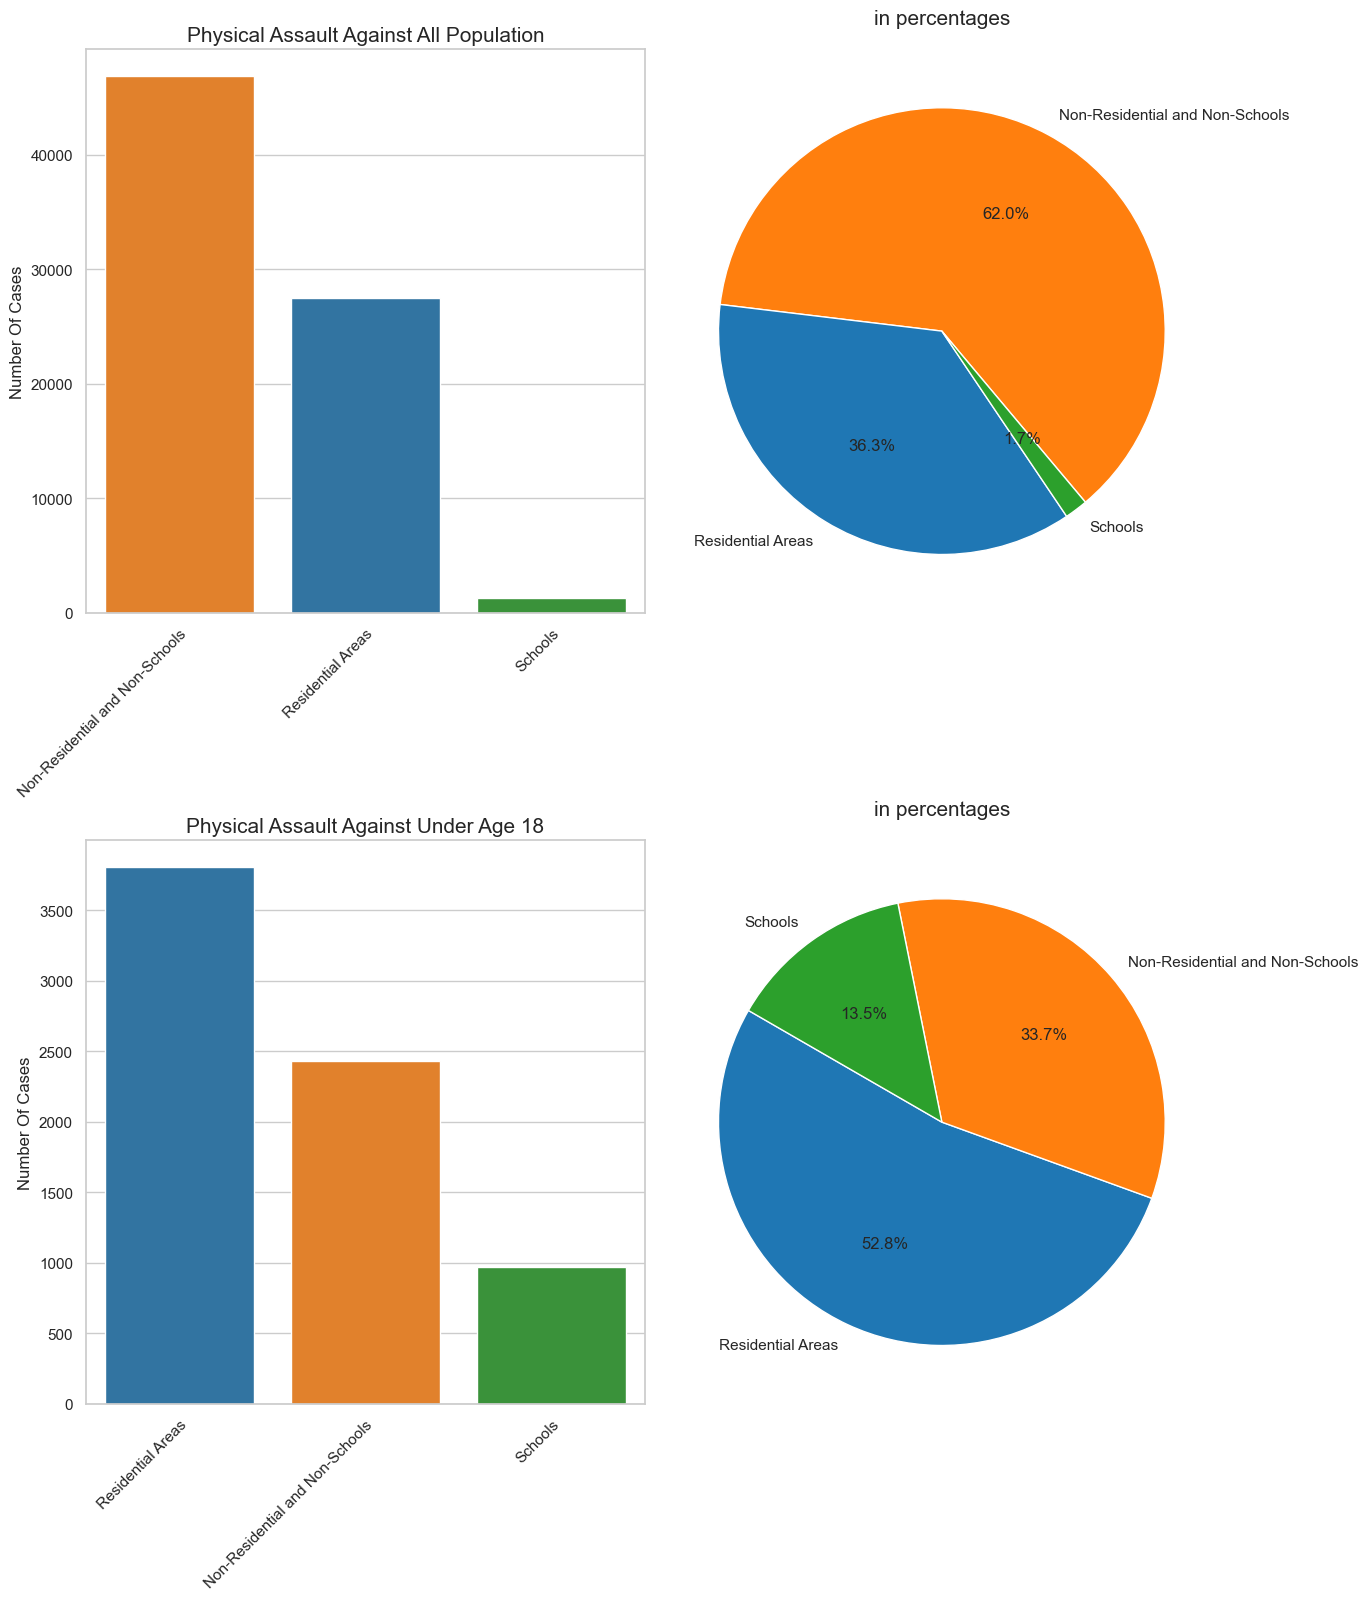

In [247]:
color_palette = {
    'Residential Areas': '#1f77b4',  # Blue
    'Non-Residential and Non-Schools': '#ff7f0e',  # Orange
    'Schools': '#2ca02c',  # Green
    'Unknown': '#d62728'  # Red
}

all_population_value_counts['color'] = all_population_value_counts['where_did_it_happen'].map(color_palette)
Under_age_18_df_value_counts['color'] = Under_age_18_df_value_counts['where_did_it_happen'].map(color_palette)


all_population_colors = [color_palette[label] for label in all_population_value_counts['where_did_it_happen']]
under_age_18_colors = [color_palette[label] for label in Under_age_18_df_value_counts['where_did_it_happen']]

fig, axs = plt.subplots(2, 2, figsize=(14, 16))


sns.barplot(data=all_population_value_counts, x='where_did_it_happen', y='count', ax=axs[0, 0], palette=all_population_value_counts['color'].tolist())
axs[0, 0].set_title('Physical Assault Against All Population', fontsize=15)
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Number Of Cases')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


axs[0, 1].pie(all_population_value_counts['count'], 
              labels=all_population_value_counts['where_did_it_happen'], 
              colors=all_population_colors, autopct='%1.1f%%', startangle=310)
axs[0, 1].set_title('in percentages', fontsize=15, pad=20)


sns.barplot(data=Under_age_18_df_value_counts, x='where_did_it_happen', y='count', ax=axs[1, 0], palette=Under_age_18_df_value_counts['color'].tolist())
axs[1, 0].set_title('Physical Assault Against Under Age 18', fontsize=15)
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Number Of Cases')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


axs[1, 1].pie(Under_age_18_df_value_counts['count'], 
              labels=Under_age_18_df_value_counts['where_did_it_happen'], 
              colors=under_age_18_colors, autopct='%1.1f%%', startangle=150)
axs[1, 1].set_title('in percentages', fontsize=15, pad=20)

plt.tight_layout()
plt.show()

ניתן לראות על פי הגרפים את ההבדלים כאשר מדובר על אלימות מתחת לגיל 18 רוב המקרם מתרחשים במתחמי מגורים ואילו כאשר מסתכלים על כלל האוכלוסייה רוב המקרים מתרחשים במרומות שהם לא מתחמי מגורים, וזה בא לידי ביטוי גם באחוזים



<h2 style="color: black;">Identity Thieves In Hollonback</h2>



<div style="text-align:center;">
    <img src="https://i.pinimg.com/236x/bf/95/b2/bf95b293aa8a0976d9e18d48014253e1.jpg" alt="תיאור התמונה" style="width: 30%;">
</div>

### The age distribution of the victims

In [248]:
identity_theft = df[df["crime_description"] == "THEFT OF IDENTITY"]

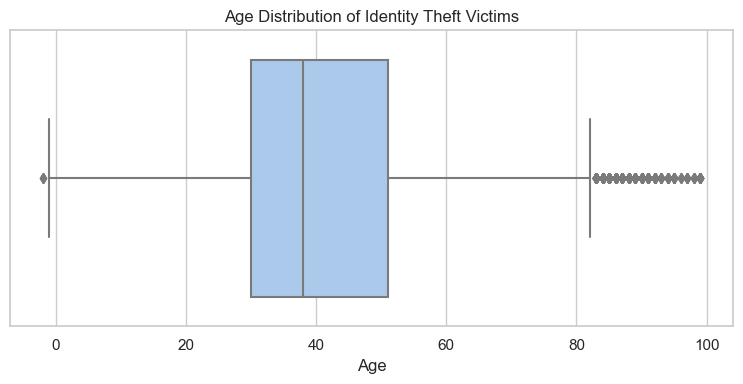

In [249]:
plt.figure(figsize=(15,4))


plt.subplot(1, 2, 1)
sns.boxplot(data=identity_theft, x='victim_age', palette='pastel')
plt.title('Age Distribution of Identity Theft Victims')
plt.xlabel('Age')
plt.tight_layout()
plt.show()

In [250]:
identity_theft_age0 = identity_theft[identity_theft['victim_age'] <= 0]
len(identity_theft_age0)


992

### There are about 992 entries where the age is 0 or less. We choose to leave them because these cases occurred, assuming complainants chose to remain anonymous or there was a mistake in entering the data

### Analyzing the crime areas where identity theft crimes happend


In [251]:
idt_by_area = identity_theft['area_name'].value_counts().reset_index()
idt_by_area.columns = ["area_name","amount"]



###  Analyzing the crime places where identity theft crimes happend

In [252]:
place_counts = identity_theft['premise_description'].value_counts().reset_index()
place_counts.columns = ['place', 'count']
place_counts.head()


,place,count
0,SINGLE FAMILY DWELLING,26250
1,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",12915
2,BANK,2452
3,AUTOMATED TELLER MACHINE (ATM),2205
4,CYBERSPACE,1592


### Classifying places involved with money and check in which areas these places are most common for identity theft

In [253]:
selected_premises = [
    "BANK DROP BOX/MONEY DROP-OUTSIDE OF BANK",
    "DRIVE THRU BANKING (WINDOW)",
    "BANKING INSIDE MARKET-STORE",
    "CHECK CASHING",
    "SAVINGS & LOAN",
    "FINANCE COMPANY",
    "CREDIT UNION",
    "AUTOMATED TELLER MACHINE (ATM)",
    "BANK"
]

idt = identity_theft[identity_theft['premise_description'].isin(selected_premises)]
idt_area_name = idt['area_name'].value_counts().reset_index()
idt_area_name.columns = ['area_name', 'amount']


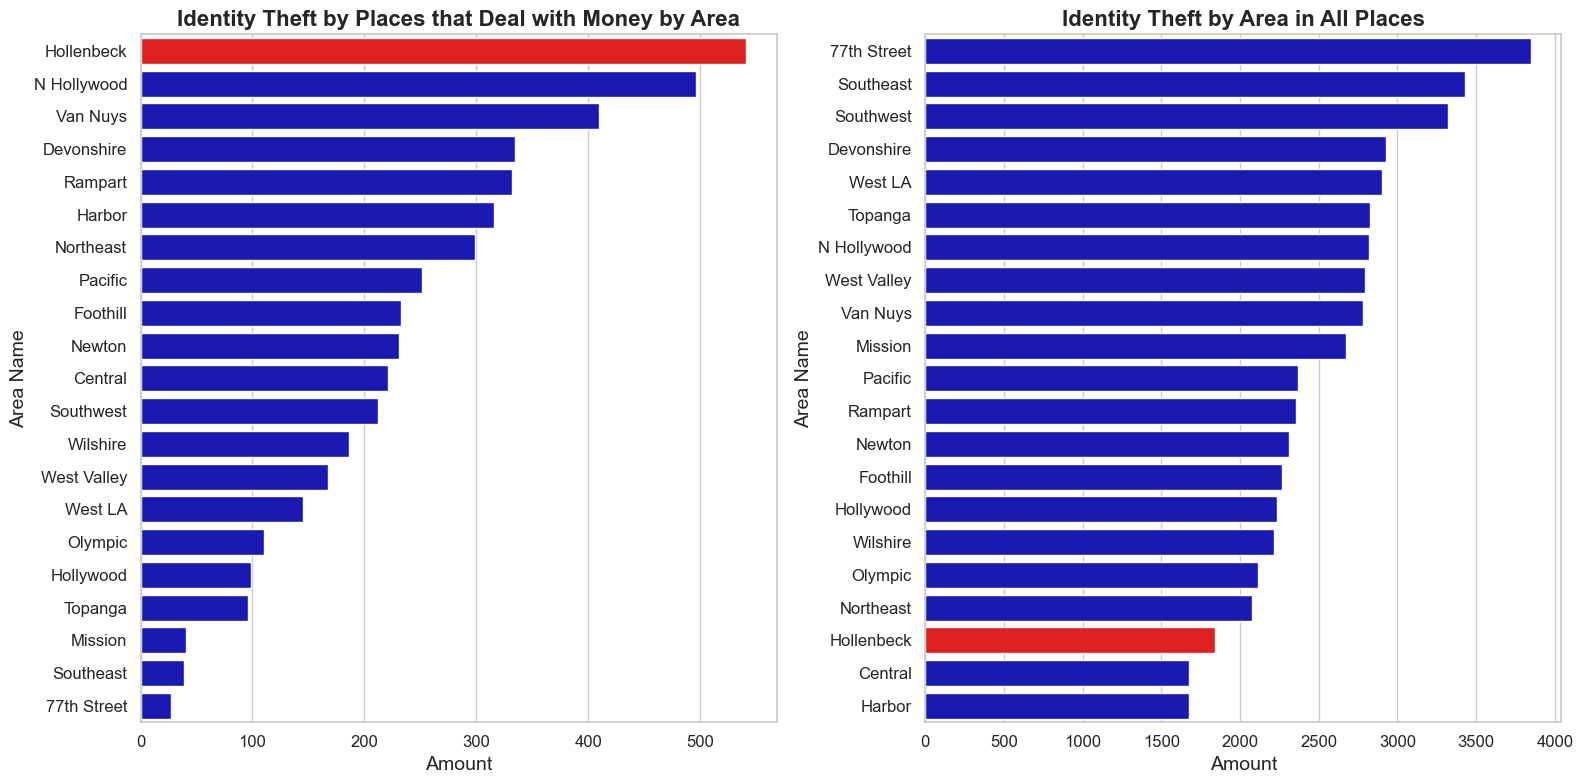

In [254]:
colors_area_name = ['#ff0000' if area == 'Hollenbeck' else '#0000cd' for area in idt_area_name['area_name']]
colors_by_area = ['#ff0000' if area == 'Hollenbeck' else '#0000cd' for area in idt_by_area['area_name']]


fig, axs = plt.subplots(1, 2, figsize=(16, 8))


sns.barplot(data=idt_area_name, x='amount', y='area_name', ax=axs[0], palette=colors_area_name)
axs[0].set_title('Identity Theft by Places that Deal with Money by Area', fontsize=16, weight='bold')
axs[0].set_xlabel('Amount', fontsize=14)
axs[0].set_ylabel('Area Name', fontsize=14)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)


sns.barplot(data=idt_by_area, x='amount', y='area_name', ax=axs[1], palette=colors_by_area)
axs[1].set_title('Identity Theft by Area in All Places', fontsize=16, weight='bold')
axs[1].set_xlabel('Amount', fontsize=14)
axs[1].set_ylabel('Area Name', fontsize=14)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()


plt.show()

### Hollonback is the area that ranks third from last overall in crime, but ranks first in crimes related to money

### Analyzing which population suffers the most from identity theft in places primarily concerned with money in the Hollonback area

In [255]:
idt_Hollenbeck = identity_theft[(identity_theft['premise_description'].isin(selected_premises)) & (identity_theft['area_name'] == 'Hollenbeck')]
idt_Hollenbeck_by_descent = idt_Hollenbeck['victim_descent'].value_counts().reset_index()
idt_Hollenbeck_by_descent.columns = ['victim_descent', 'amount']


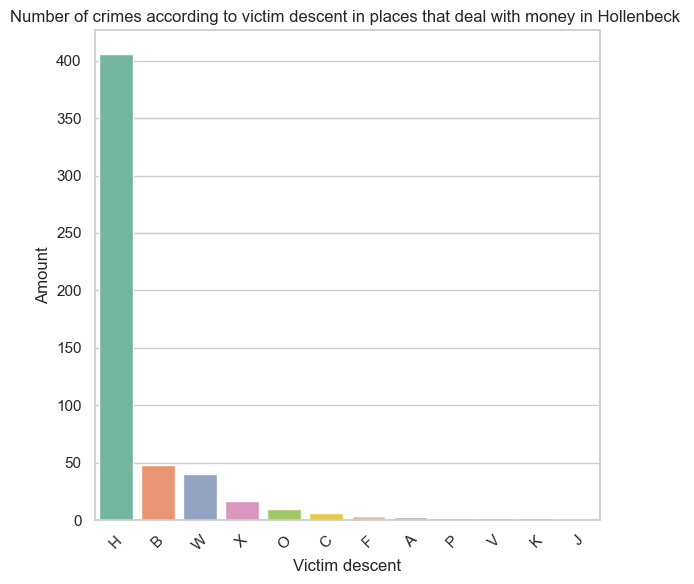

In [256]:
custom_palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(6, 6))


sns.barplot(x='victim_descent', y='amount', data=idt_Hollenbeck_by_descent, palette=custom_palette, ax=ax)

ax.set_title("Number of crimes according to victim descent in places that deal with money in Hollenbeck ")
ax.set_xlabel("Victim descent")
ax.set_ylabel("Amount")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### It can be seen that Hispanics suffer the most from identity theft in areas where their primary occupation is related to money

In [257]:
idt_Hollenbeck['category'] = idt_Hollenbeck['victim_descent'].apply(lambda x: 'H' if x == 'H' else 'Everything Else')
idt_Hollenbeck_by_descent = idt_Hollenbeck['category'].value_counts().reset_index()
idt_Hollenbeck_by_descent.columns = ['victim_descent', 'amount']


In [258]:
idt_in_all_places_by_descent = identity_theft["victim_descent"].value_counts().reset_index()
idt_in_all_places_by_descent.columns = ["victim_descent", "amount"]
identity_theft['category'] = identity_theft['victim_descent'].apply(lambda x: 'H' if x == 'H' else 'Everything Else')

idt_in_all_places_by_descent = identity_theft['category'].value_counts().reset_index()
idt_in_all_places_by_descent.columns = ["victim_descent", "amount"]



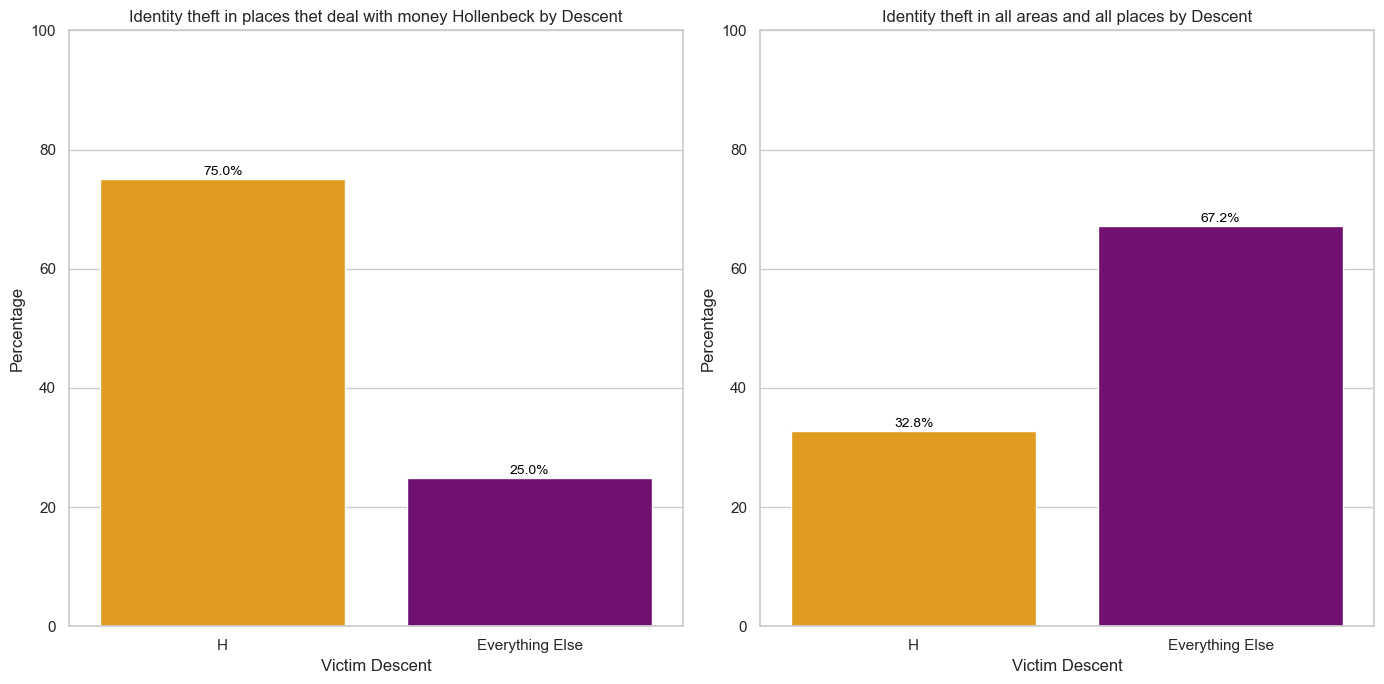

In [259]:
idt_Hollenbeck_by_descent['amount'] = (idt_Hollenbeck_by_descent['amount'] / idt_Hollenbeck_by_descent['amount'].sum()) * 100
idt_in_all_places_by_descent['amount'] = (idt_in_all_places_by_descent['amount'] / idt_in_all_places_by_descent['amount'].sum()) * 100


idt_in_all_places_by_descent = idt_in_all_places_by_descent.sort_values(by='victim_descent', ascending=False)


fig, axes = plt.subplots(1, 2, figsize=(14, 7))


colors_hollenbeck = ['orange' if descent == 'H' else 'purple' for descent in idt_Hollenbeck_by_descent['victim_descent']]
sns.barplot(x='victim_descent', y='amount', data=idt_Hollenbeck_by_descent, palette=colors_hollenbeck, ax=axes[0])
axes[0].set_title('Identity theft in places thet deal with money Hollenbeck by Descent')
axes[0].set_xlabel('Victim Descent')
axes[0].set_ylabel('Percentage')
axes[0].set_ylim(0, 100)


for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')


colors_all_places = ['orange' if descent == 'H' else 'purple' for descent in idt_in_all_places_by_descent['victim_descent']]
sns.barplot(x='victim_descent', y='amount', data=idt_in_all_places_by_descent, palette=colors_all_places, ax=axes[1])
axes[1].set_title('Identity theft in all areas and all places by Descent')
axes[1].set_xlabel('Victim Descent')
axes[1].set_ylabel('Percentage')
axes[1].set_ylim(0, 100)


for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

<div style="
    text-align: left;
    font-size: 32px;
    font-weight: bold;
    color: #000000;
    text-shadow: 2px 2px 5px #888888;
    margin-top: 20px;
    margin-bottom: 20px;
    font-family: Arial, sans-serif;">
   First Conclusion
</div>


### The Hispanic population is an "easy target" for identity thieves who operate in Hollenbeck

## Burglaries Of Elderly Properties

In [260]:
old_df = df[df["age_description"]== "old"]

old_df_crime_description = old_df['crime_description'].value_counts().reset_index()
old_df_crime_description.columns = ['crime_description', 'count']

old_df_crime_description.head(20)


,crime_description,count
0,BATTERY - SIMPLE ASSAULT,9901
1,BURGLARY,8426
2,THEFT OF IDENTITY,7226
3,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",5190
4,THEFT PLAIN - PETTY ($950 & UNDER),5010
5,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,4778
6,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",4681
7,BURGLARY FROM VEHICLE,4323
8,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",3131
9,VANDALISM - MISDEAMEANOR ($399 OR UNDER),2983


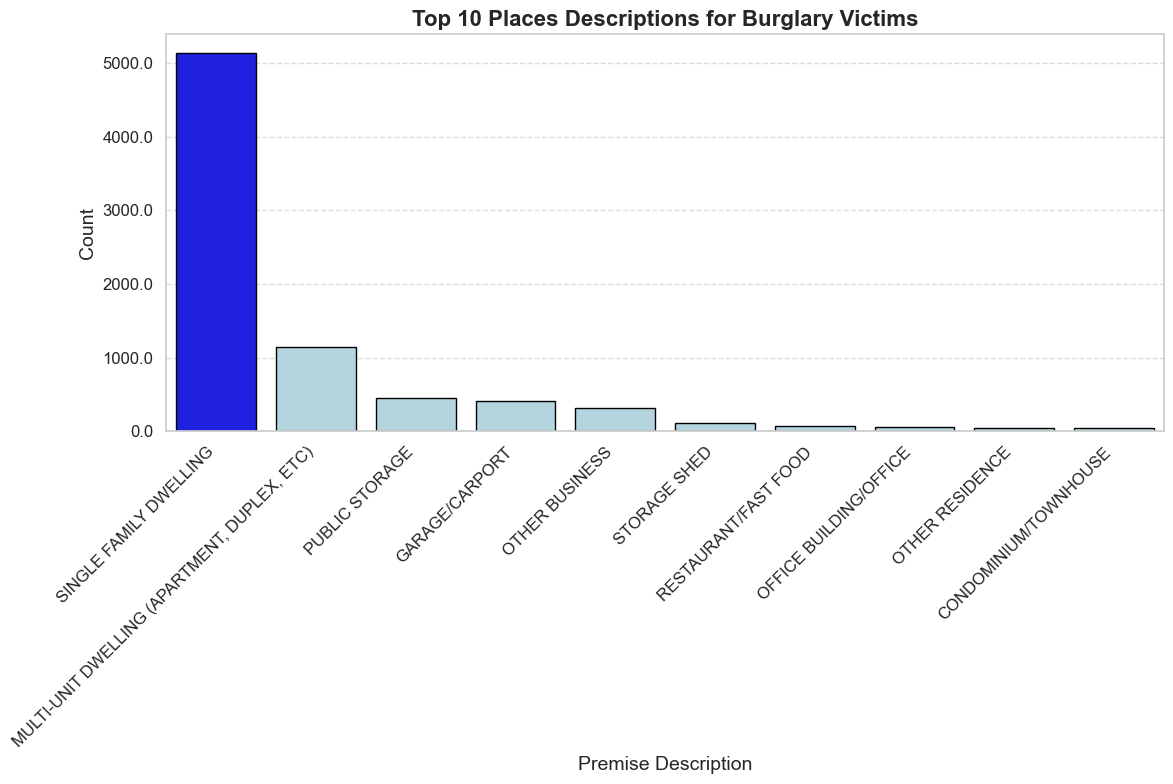

In [261]:
old_burglary_df = old_df[old_df["crime_description"] == "BURGLARY"]
premise_description_counts = old_burglary_df['premise_description'].value_counts().reset_index()
premise_description_counts.columns = ['premise_description', 'count']
top_10_premise_descriptions = premise_description_counts.head(10)


fig, ax = plt.subplots(figsize=(12, 8))


colors = ['lightblue' if count != top_10_premise_descriptions['count'].max() else 'blue' for count in top_10_premise_descriptions['count']]


sns.barplot(x='premise_description', y='count', data=top_10_premise_descriptions, palette=colors, edgecolor='black', ax=ax)


ax.set_xlabel('Premise Description', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Top 10 Places Descriptions for Burglary Victims', fontsize=16, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)


ax.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

### According to the diagram, it seems that the most common crime against the elderly is burglary of their property

### Checking if there's a trend of increase or decrease in cases over the years

In [262]:
old_burglary_df['year_occurred'] = old_burglary_df['date_occurred'].dt.year
yearly_counts_old_burglary_df = old_burglary_df['year_occurred'].value_counts().reset_index()
yearly_counts_old_burglary_df.columns = ['year', 'amount_burglaries']
yearly_counts_old_burglary_df


,year,amount_burglaries
0,2023,2393
1,2022,2271
2,2021,1899
3,2020,1863


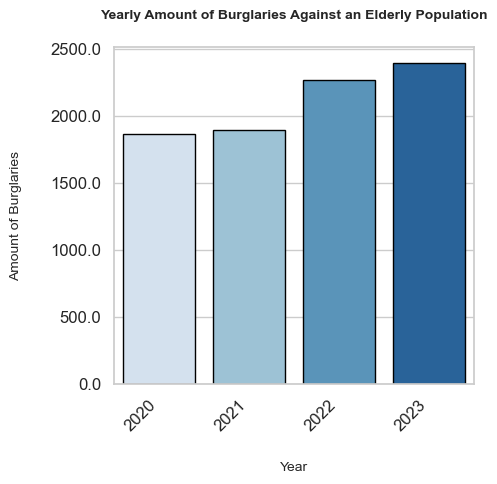

In [263]:
yearly_counts_old_burglary_df['year'] = yearly_counts_old_burglary_df['year'].astype(int)


fig, ax = plt.subplots(figsize=(5,5))


sns.barplot(x='year', y='amount_burglaries', data=yearly_counts_old_burglary_df, palette="Blues", edgecolor='black', ax=ax)


ax.set_xlabel('Year', fontsize=10, labelpad=20)
ax.set_ylabel('Amount of Burglaries', fontsize=10, labelpad=20)
ax.set_title('Yearly Amount of Burglaries Against an Elderly Population', fontsize=10, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)


ax.yaxis.get_major_locator().set_params(integer=True)


plt.tight_layout()
plt.show()

### There has been an increase over the years in the number of burglaries targeting the elderly population

### Trying to understand the number of perpetrators involved in burglaries

In [264]:
status_description_counts = old_burglary_df['status_description'].value_counts().reset_index()
status_description_counts.columns = ['status_description', 'count']
status_description_counts

,status_description,count
0,Invest Cont,7716
1,Adult Arrest,521
2,Adult Other,185
3,Juv Arrest,4


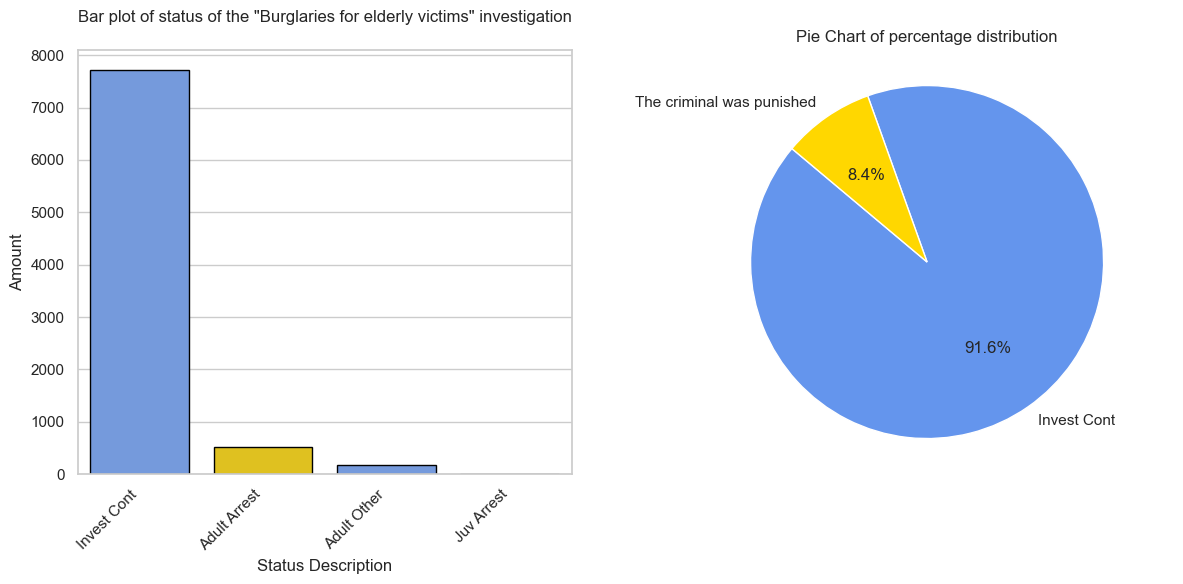

In [265]:
invest_cont_count = status_description_counts[status_description_counts['status_description'] == "Invest Cont"]['count'].sum()
other_count = status_description_counts['count'].sum() - invest_cont_count

status_description_simplified = pd.DataFrame({
    'status_description': ['Invest Cont', 'The criminal was punished'],
    'count': [invest_cont_count, other_count]
})


fig, axes = plt.subplots(1, 2, figsize=(12, 6))


colors = ["#6495ED", "#FFD700"]
axes[1].pie(status_description_simplified['count'], labels=status_description_simplified['status_description'], autopct='%1.1f%%', colors=colors, startangle=140)
axes[1].set_title('Pie Chart of percentage distribution')
axes[1].axis('equal')


sns.barplot(x='status_description', y='count', data=status_description_counts, palette=colors, edgecolor='black', ax=axes[0])


axes[0].set_xlabel('Status Description')
axes[0].set_ylabel('Amount')
axes[0].set_title('Bar plot of status of the "Burglaries for elderly victims" investigation',fontsize=12, pad=20)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


plt.tight_layout()
plt.show()

### According to the graphs, nearly all reported cases of burglaries involve elderly individuals, with investigations remaining open, indicating that most burglars are not apprehended

### Checking if there is a trend of increase or decrease in the number of criminals punished over the years

In [266]:
status_description_yearly_counts = old_burglary_df.groupby(['year_occurred', 'status_description']).size().reset_index(name='count')


pivot_table = status_description_yearly_counts.pivot(index='year_occurred', columns='status_description', values='count').fillna(0)


pivot_table

status_description,Adult Arrest,Adult Other,Invest Cont,Juv Arrest
year_occurred,,,,
2020,147.0,69.0,1646.0,1.0
2021,146.0,38.0,1715.0,0.0
2022,132.0,45.0,2092.0,2.0
2023,96.0,33.0,2263.0,1.0


In [267]:
required_columns = ['Adult Arrest', 'Adult Other', 'Juv Arrest']
for col in required_columns:
    if col not in pivot_table.columns:
        pivot_table[col] = 0


result_df = pivot_table.reset_index()
result_df['The criminal was punished'] = result_df[required_columns].sum(axis=1)
result_df = result_df[['year_occurred', 'Invest Cont', 'The criminal was punished']]


result_df = result_df.fillna(0)

result_df.columns = ['Year', 'Invest Cont', 'criminals_punished']


,Year,Invest Cont,criminals_punished
0,2020,1646.0,217.0
1,2021,1715.0,184.0
2,2022,2092.0,179.0
3,2023,2263.0,130.0


In [268]:
result_df = pivot_table.reset_index()
result_df['The criminal was punished'] = result_df[required_columns].sum(axis=1)
result_df = result_df[['year_occurred', 'Invest Cont', 'The criminal was punished']]


result_df = result_df.fillna(0)
result_df.columns = ['year', 'Invest Cont', 'criminals_punished']
result_df

,year,Invest Cont,criminals_punished
0,2020,1646.0,217.0
1,2021,1715.0,184.0
2,2022,2092.0,179.0
3,2023,2263.0,130.0


In [269]:
result_subset = result_df[['criminals_punished', 'year']]
yearly_counts_subset = yearly_counts_old_burglary_df[['amount_burglaries', 'year']]


final_df = pd.merge(result_subset, yearly_counts_subset, on='year')


final_df = final_df[['year', 'amount_burglaries', 'criminals_punished']]



,year,amount_burglaries,criminals_punished
0,2020,1863,217.0
1,2021,1899,184.0
2,2022,2271,179.0
3,2023,2393,130.0


### Checking the correlation between the increase in the number of burglaries and the decrease in the number of burglars caught in recent years

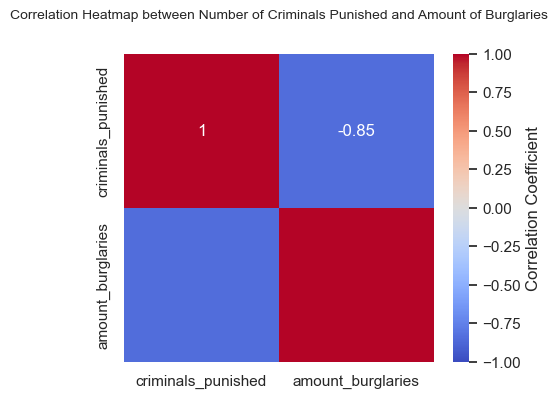

In [270]:
correlation_data = final_df[['criminals_punished', 'amount_burglaries']]
correlation_matrix = correlation_data.corr()


plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap between Number of Criminals Punished and Amount of Burglaries', fontsize=10 , pad=25)
plt.show()






### Based on correlation data, it can be inferred that there is a trend where as the number of prosecuted offenders decreases, the number of burglaries increases. This correlation, estimated at -0.85, indicates a strong negative relationship between the two phenomena

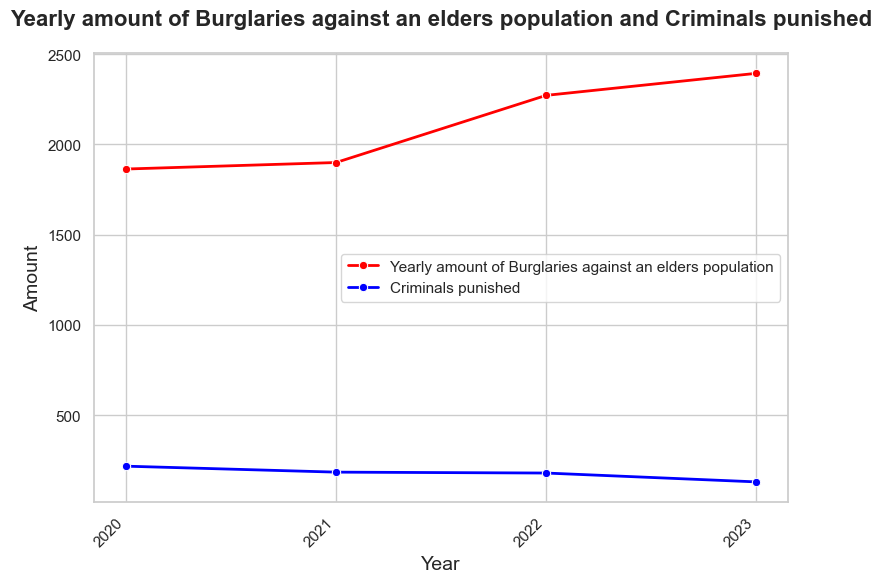

In [271]:
sns.set_theme(style="whitegrid")


final_df['year'] = final_df['year'].astype(int)
result_df['year'] = result_df['year'].astype(int)


plt.figure(figsize=(8, 6))


sns.lineplot(x='year', y='amount_burglaries', data=final_df, color='red', marker='o', linestyle='-', linewidth=2, markersize=6, label='Yearly amount of Burglaries against an elders population')
sns.lineplot(x='year', y='criminals_punished', data=result_df, color='blue', marker='o', linestyle='-', linewidth=2, markersize=6, label='Criminals punished')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.title('Yearly amount of Burglaries against an elders population and Criminals punished', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<div style="
    text-align: left;
    font-size: 32px;
    font-weight: bold;
    color: #000000;
    text-shadow: 2px 2px 5px #888888;
    margin-top: 20px;
    margin-bottom: 20px;
    font-family: Arial, sans-serif;">
    Second Conclusion
</div>


## The police are not effective in protecting the elderly population from burglaries of homes, properties, and businesses, which is the most affected population - both in preventing and eradicating the phenomenon, as well as in handling existing cases 


<div style="text-align:center;">
    <img src="https://i.pinimg.com/236x/93/74/06/937406df9143e80ebaa82e96919fba8e.jpg" alt="תיאור התמונה" style="width: 30%;">
</div>

## Use Of Firearms On 77th Street

In [272]:
firearm_df = df[df["weapon_category"] == "firearm"] 
sharp_weapon_df = df[df["weapon_category"] == "Physical strength"]

area_name_counts = firearm_df['area_name'].value_counts().reset_index()

area_name_counts.columns = ['area_name', 'count']





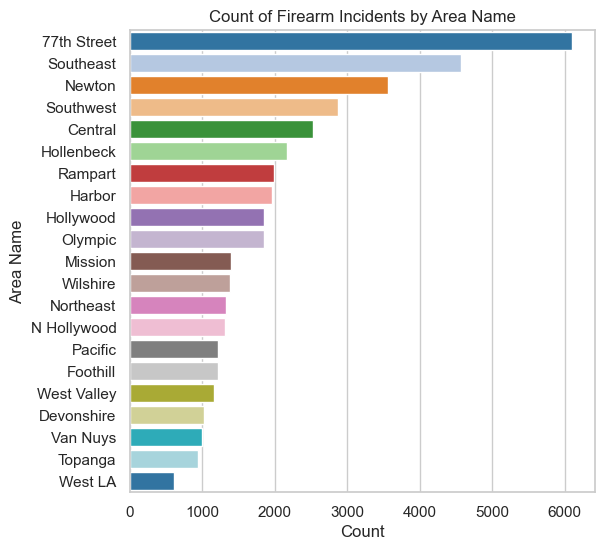

In [273]:
palette = sns.color_palette("tab20", len(area_name_counts))


sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(6,6))


bar_plot = sns.barplot(data=area_name_counts, y='area_name', x='count', palette=palette, ax=ax)


ax.set_title('Count of Firearm Incidents by Area Name')
ax.set_xlabel('Count')
ax.set_ylabel('Area Name')

plt.show()

### We can see that the most common area for firearm use is 77th Street

 ### Examining the locations where the highest number of crimes involving the use of firearms occurred on 77th Street

In [274]:
th77_firearm_df = firearm_df[firearm_df["area_name"] =="77th Street"]
premise_description_counts = th77_firearm_df['premise_description'].value_counts().reset_index()
premise_description_counts.columns = ['premise_description', 'count']
premise_description_counts.head(10)

,premise_description,count
0,STREET,3041
1,SINGLE FAMILY DWELLING,744
2,SIDEWALK,587
3,PARKING LOT,342
4,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",294
5,ALLEY,138
6,OTHER BUSINESS,105
7,GAS STATION,96
8,DRIVEWAY,85
9,"VEHICLE, PASSENGER/TRUCK",57


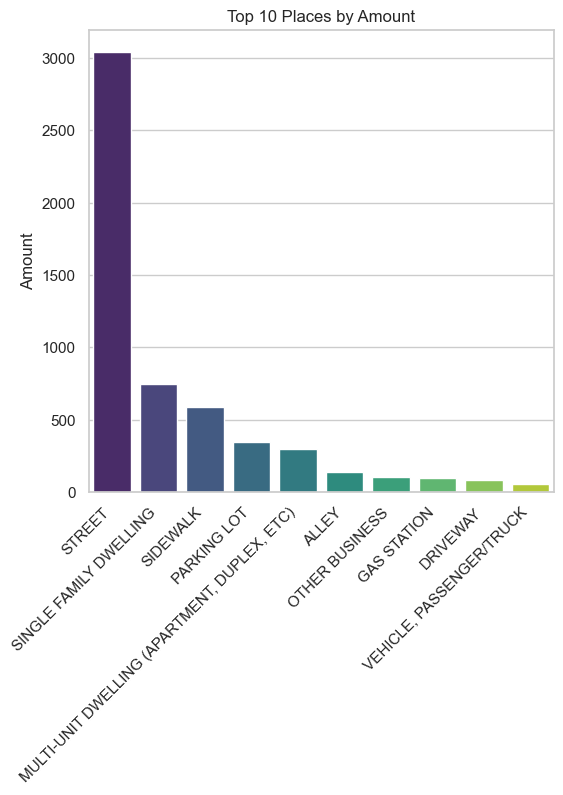

In [275]:
fig, ax = plt.subplots(figsize=(6,6))


palette = sns.color_palette("viridis", n_colors=10)
sns.barplot(x='premise_description', y='count', data=premise_description_counts.head(10), ax=ax, palette=palette)


ax.set_title('Top 10 Places by Amount')
ax.set_xlabel('')
ax.set_ylabel('Amount')


plt.xticks(rotation=45,ha = "right")


plt.show()

### we can see that most cases occurred on the street

### Creating a new column that will provide information on whether the crime was committed in a public or private place

In [276]:
public_places = [
    'TRAIN TRACKS',
    'TOW YARD',
    'OTHER/OUTSIDE',
    'TUNNEL',
    'VACANT LOT',
    'SWAP MEET',
    'FREEWAY',
    'SHOPPING MALL (COMMON AREA)',
    'PARK/PLAYGROUND',
    'MARKET',
    'BUS STOP',
    'GAS STATION',
    'ALLEY',
    'PARKING LOT',
    'SIDEWALK',
    'STREET',
    "TRANSIENT ENCAMPMENT",
]


th77_firearm_df['public_or_private'] = th77_firearm_df['premise_description'].apply(lambda x: 'public place' if x in public_places else 'private place')


In [277]:
public_private_counts = th77_firearm_df['public_or_private'].value_counts().reset_index()
public_private_counts.columns = ["public_or_private", "count"]
public_private_counts

,public_or_private,count
0,public place,4306
1,private place,1800


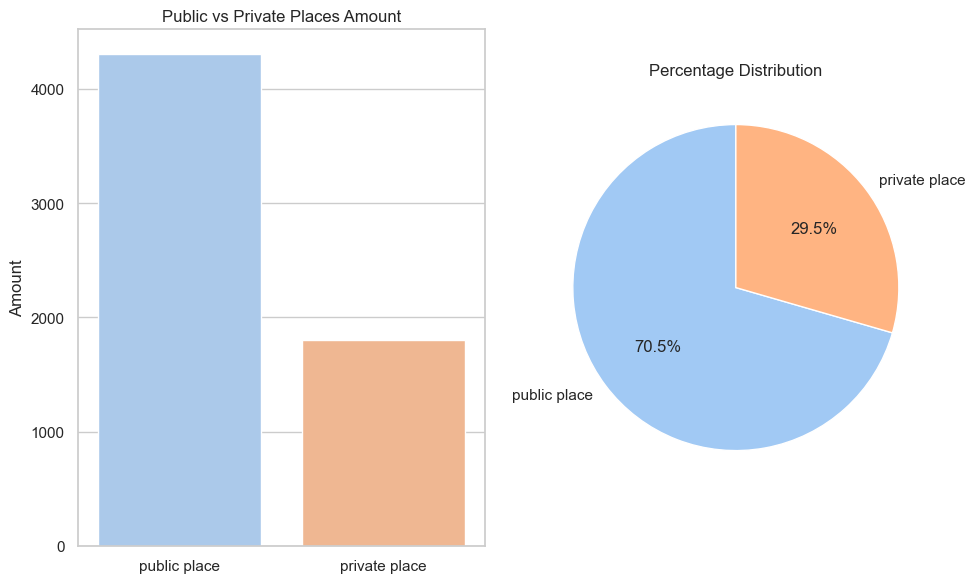

In [278]:
colors = sns.color_palette("pastel")[0:2]


fig, axes = plt.subplots(1, 2, figsize=(10,6))


sns.barplot(x='public_or_private', y='count', data=public_private_counts, ax=axes[0], palette=colors)
axes[0].set_title('Public vs Private Places Amount')
axes[0].set_xlabel('')
axes[0].set_ylabel('Amount')


axes[1].pie(public_private_counts['count'], labels=public_private_counts['public_or_private'], autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Percentage Distribution')


plt.tight_layout()
plt.show()

### There is a noticeable difference in the use of firearms in committing offenses in public places compared to private places

### Examining if there is a trend in the use of firearms over the years

In [279]:
area_year_counts = th77_firearm_df.groupby(['public_or_private', 'year_occurred']).size().reset_index(name='count')




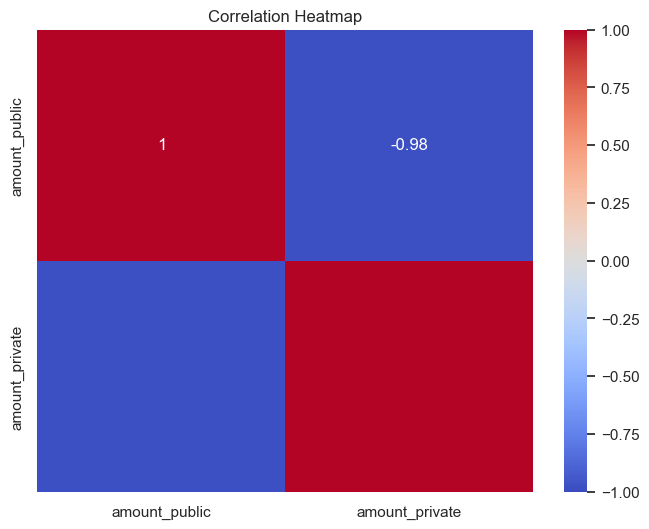

In [280]:
public_counts = area_year_counts[area_year_counts['public_or_private'] == 'public place'][['year_occurred', 'count']].rename(columns={'count': 'amount_public'})
private_counts = area_year_counts[area_year_counts['public_or_private'] == 'private place'][['year_occurred', 'count']].rename(columns={'count': 'amount_private'})


merged_counts = pd.merge(public_counts, private_counts, on='year_occurred', how='outer')


merged_counts.fillna(0, inplace=True)


correlation_matrix = merged_counts[['amount_public', 'amount_private']].corr()


plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)


plt.title('Correlation Heatmap')


plt.show()


### The strong negative correlation explains the strong relationship between crimes committed using firearms in public locations versus those in private locations in 77th Street

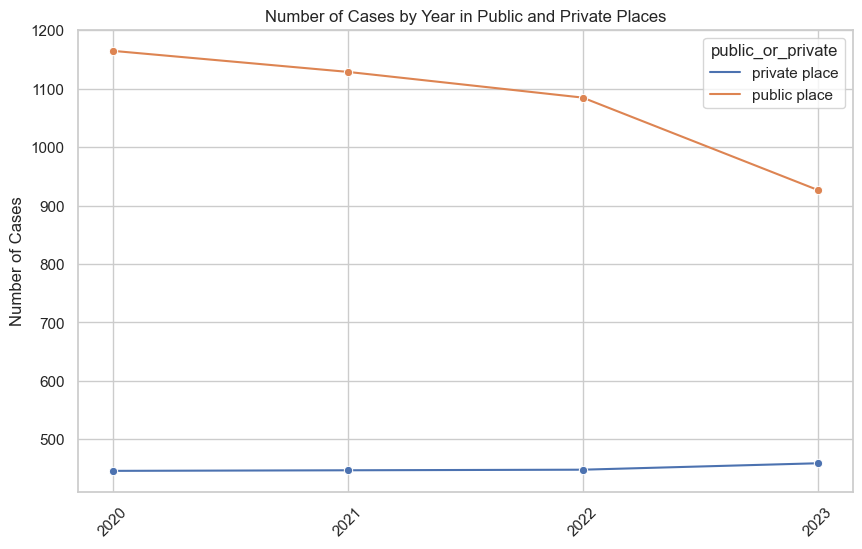

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))


sns.lineplot(data=area_year_counts, x='year_occurred', y='count', hue='public_or_private', marker='o', ax=ax)


ax.set_title('Number of Cases by Year in Public and Private Places')
ax.set_xlabel('')
ax.set_ylabel('Number of Cases')


ax.set_xticks(area_year_counts['year_occurred'].unique())
ax.set_xticklabels(area_year_counts['year_occurred'].unique(), rotation=45)


plt.show()

<div style="
    text-align: left;
    font-size: 32px;
    font-weight: bold;
    color: #000000;
    text-shadow: 2px 2px 5px #888888;
    margin-top: 20px;
    margin-bottom: 20px;
    font-family: Arial, sans-serif;">
    Third Conclusion
</div>

### Based on the data, we can understand that the police allocate most of their efforts to crimes involving the use of firearms committed in public places, while neglecting those in private locations

## Pickpocket In Los Angeles

In [282]:
chipopo_df = df[df["crime_description"] == "PICKPOCKET"]



In [283]:
area_name_counts = chipopo_df['area_name'].value_counts().reset_index()
area_name_counts.columns = ['area_name', 'count']
area_name_counts

,area_name,count
0,Central,539
1,Hollywood,510
2,Southwest,264
3,Wilshire,185
4,Olympic,154
5,Newton,112
6,Northeast,112
7,Rampart,96
8,Pacific,89
9,West LA,83


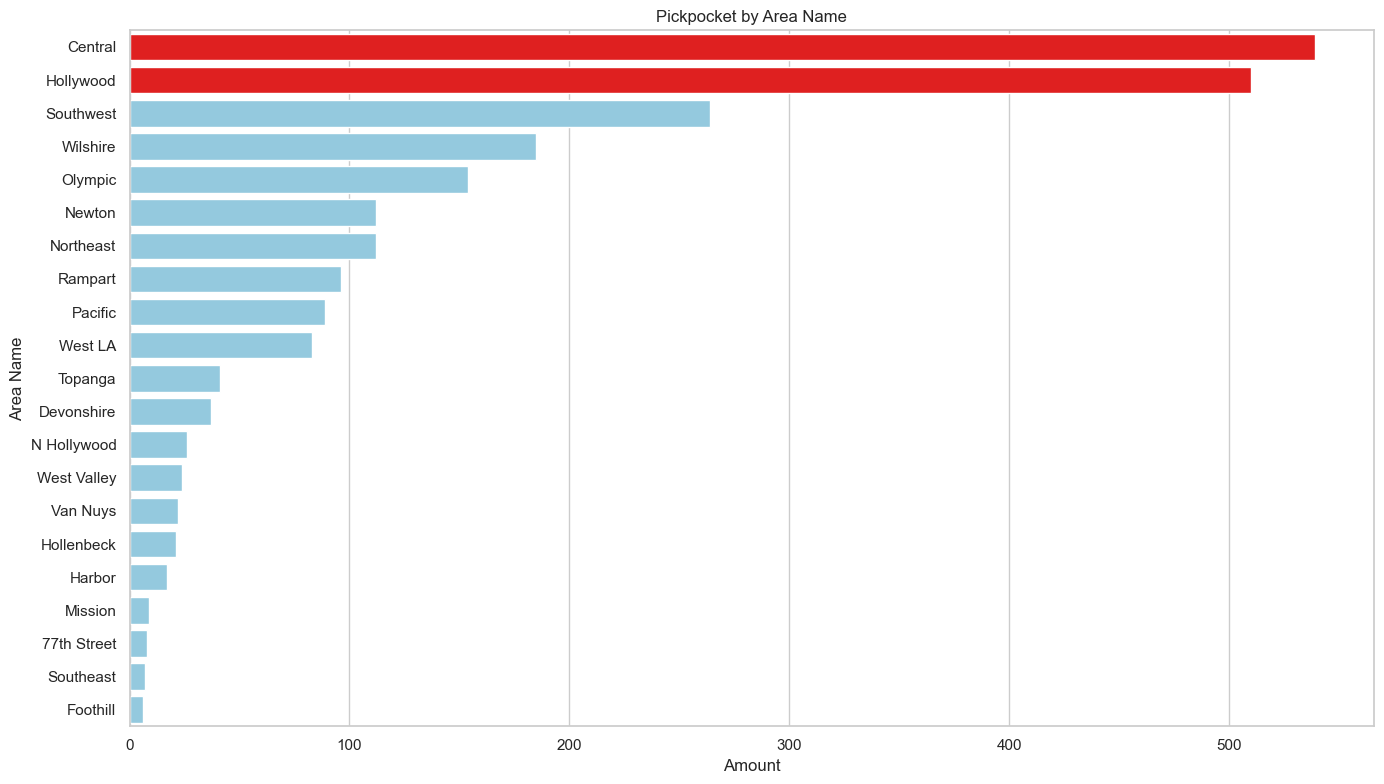

In [284]:
colors = ['red' if area in ['Central', 'Hollywood'] else 'skyblue' for area in area_name_counts['area_name']]

# Create a bar plot for all area names with highlighted areas
plt.figure(figsize=(14, 8))
sns.barplot(x='count', y='area_name', data=area_name_counts, palette=colors)

plt.title('Pickpocket by Area Name')
plt.xlabel('Amount')
plt.ylabel('Area Name')
plt.tight_layout()

# Show the plot
plt.show()

### The majority of pickpocketing incidents occur in Hollywood and Central

In [285]:
CentralANDHollywood_df = chipopo_df[chipopo_df['area_name'].isin(['Central', 'Hollywood'])]
hour_counts_ch = CentralANDHollywood_df['hour_occurred'].value_counts().reset_index()
hour_counts_ch.columns = ['hour_occurred', 'count']

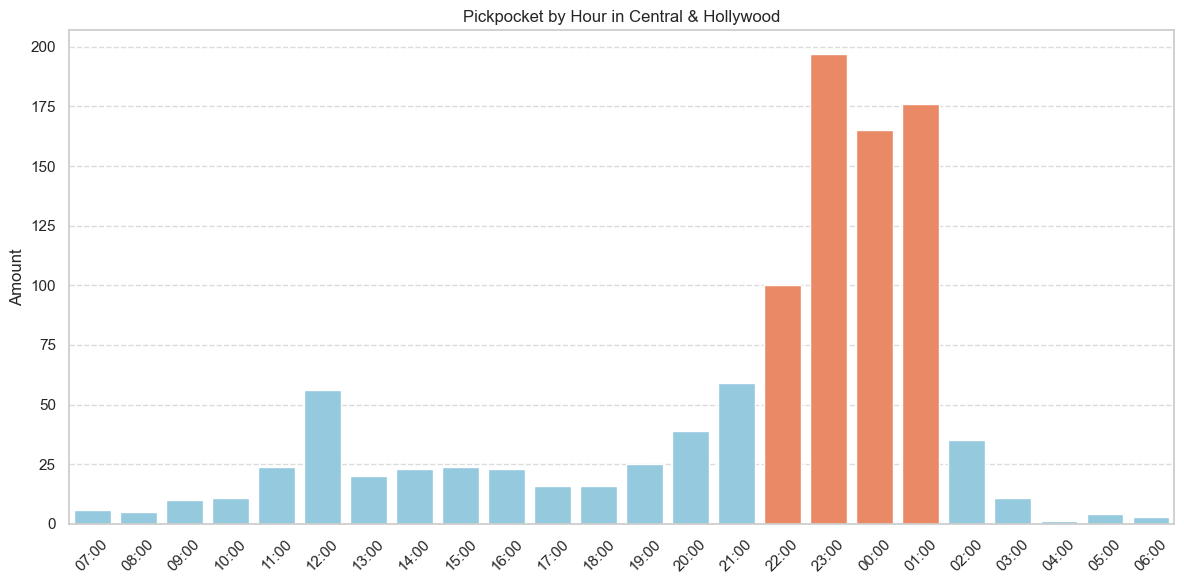

In [286]:
custom_order = list(range(7, 24)) + list(range(0, 7))


hour_counts_ch['hour_occurred'] = pd.Categorical(hour_counts_ch['hour_occurred'], categories=custom_order, ordered=True)
hour_counts_ch = hour_counts_ch.sort_values('hour_occurred').reset_index(drop=True)


colors = ['coral' if (hour >= 22 or hour <= 1) else 'skyblue' for hour in custom_order]


fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x=hour_counts_ch['hour_occurred'].astype(str), y=hour_counts_ch['count'], palette=colors, ax=ax)


hour_labels = [f'{hour:02d}:00' for hour in custom_order]


ax.set_xticks(range(len(custom_order)))
ax.set_xticklabels(hour_labels, rotation=45)

ax.set_xlabel('')
ax.set_ylabel('Amount')
ax.set_title('Pickpocket by Hour in Central & Hollywood')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

### Pickpockets operate primarily during the evening and nighttime hours

In [287]:
day_of_week_counts = CentralANDHollywood_df['day_of_week'].value_counts().reset_index()
day_of_week_counts.columns = ['day_of_week', 'count']
day_of_week_counts

,day_of_week,count
0,Saturday,406
1,Sunday,241
2,Friday,221
3,Thursday,72
4,Monday,42
5,Tuesday,38
6,Wednesday,29


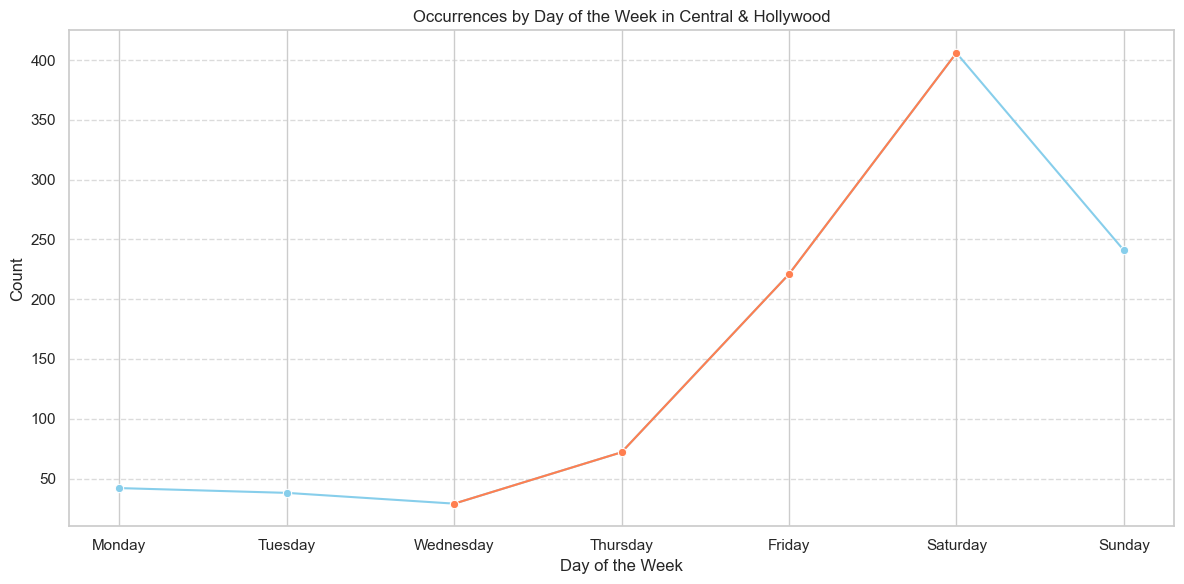

In [288]:
if 'day_of_week' not in CentralANDHollywood_df.columns:
    CentralANDHollywood_df['day_of_week'] = CentralANDHollywood_df['date_occurred'].dt.day_name()

custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_of_week_counts['day_of_week'] = pd.Categorical(day_of_week_counts['day_of_week'], categories=custom_order, ordered=True)
day_of_week_counts = day_of_week_counts.sort_values('day_of_week').reset_index(drop=True)


highlight_days = ['Wednesday', 'Thursday', 'Friday', 'Saturday']
colors = ['coral' if day in highlight_days else 'skyblue' for day in day_of_week_counts['day_of_week']]


plt.figure(figsize=(12, 6))


sns.lineplot(x='day_of_week', y='count', data=day_of_week_counts, marker='o', color='skyblue')


sns.lineplot(x='day_of_week', y='count', data=day_of_week_counts[day_of_week_counts['day_of_week'].isin(highlight_days)], marker='o', color='coral')

plt.title('Occurrences by Day of the Week in Central & Hollywood')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

### There is a sharp increase in pickpocketing incidents towards the weekend compared to other weekdays

In [289]:
premise_description_counts = CentralANDHollywood_df['premise_description'].value_counts().reset_index()
premise_description_counts.columns = ['premise_description', 'count']
premise_description_counts.head(10)

,premise_description,count
0,NIGHT CLUB (OPEN EVENINGS ONLY),319
1,BAR/COCKTAIL/NIGHTCLUB,216
2,BAR/SPORTS BAR (OPEN DAY & NIGHT),83
3,STREET,67
4,PARK/PLAYGROUND,65
5,SIDEWALK,61
6,OTHER/OUTSIDE,30
7,OTHER BUSINESS,26
8,CONVENTION CENTER,21
9,OTHER PREMISE,16


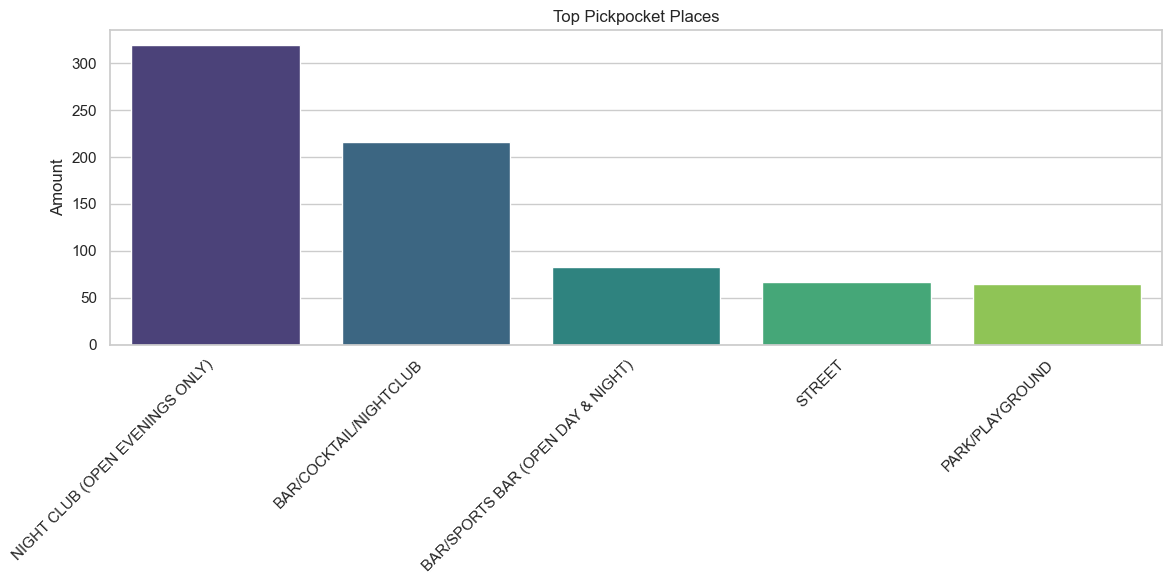

In [290]:
top_5_premise_description_counts = premise_description_counts.head(5)


plt.figure(figsize=(12, 6))
sns.barplot(x='premise_description', y='count', data=top_5_premise_description_counts, palette='viridis')

plt.title('Top Pickpocket Places')
plt.xlabel('')
plt.ylabel('Amount')
plt.xticks(rotation=45,ha = "right")
plt.tight_layout()


plt.show()

### The leading locations for pickpocketing are entertainment venues

<div style="text-align:left;">
    <img src="https://f4.bcbits.com/img/a0839767317_16.jpg" alt="תיאור התמונה" style="width: 40%;">
</div>

In [291]:


 ### Creating a new column that will help us understand how many cases occurred at entertainment venues

In [292]:
hang_out_places = [
    'STAPLES CENTER *', 'BAR/COCKTAIL/NIGHTCLUB',
    'SHOPPING MALL (COMMON AREA)', 'DISCOUNT STORE (99 CENT,DOLLAR,ETC.',
    'BEACH', 'BAR/SPORTS BAR (OPEN DAY & NIGHT)', 'RESTAURANT/FAST FOOD',
    'COLISEUM', 'MINI-MART', 'NIGHT CLUB (OPEN EVENINGS ONLY)', 'THE GROVE',
    'CLOTHING STORE', 'CONVENTION CENTER', 'DEPARTMENT STORE',
    "COFFEE SHOP (STARBUCKS, COFFEE BEAN, PEET'S, ETC.)", 'LIQUOR STORE',
    'SPORTS VENUE, OTHER', 'THEATRE/MOVIE', 'SPORTS ARENA',
    'ENTERTAINMENT/COMEDY CLUB (OTHER)', 'MEMBERSHIP STORE (COSTCO,SAMS CLUB)*',
    "DIY CENTER (LOWE'S,HOME DEPOT,OSH,CONTRACTORS WAREHOUSE)", 'THE BEVERLY CONNECTION',
    'DODGER STADIUM', 'HOTEL', '*', 'MUSEUM', 'AMUSEMENT PARK*',
    'YARD (RESIDENTIAL/BUSINESS)', 'MASS GATHERING LOCATION',
    "SEX ORIENTED/BOOK STORE/STRIP CLUB/GENTLEMAN'S CLUB", 'OPTICAL OFFICE INSIDE STORE OR SUPERMARKET*'
]


CentralANDHollywood_df['hang-out place'] = CentralANDHollywood_df['premise_description'].isin(hang_out_places)

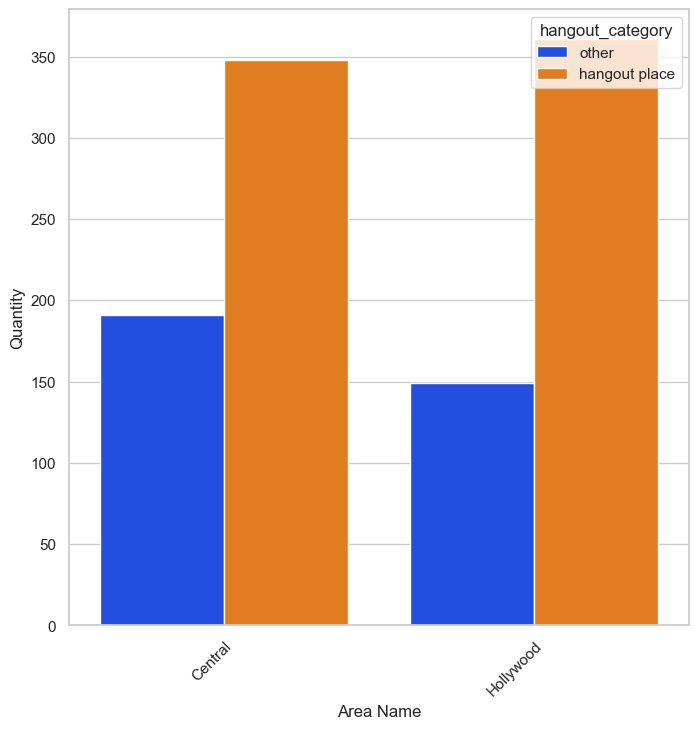

In [293]:
CentralANDHollywood_df['hangout_category'] = CentralANDHollywood_df['hang-out place'].apply(lambda x: 'hangout place' if x else 'other')


fig, ax = plt.subplots(figsize=(8,8))


sns.countplot(data=CentralANDHollywood_df, x='area_name', hue='hangout_category', ax=ax, palette='bright')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_title('')
ax.set_xlabel('Area Name')
ax.set_ylabel('Quantity')

plt.show()












### Both in Central and Hollywood, most incidents occur primarily at entertainment venues

### Examining what happened over the years regarding crimes in Hollywood and Central

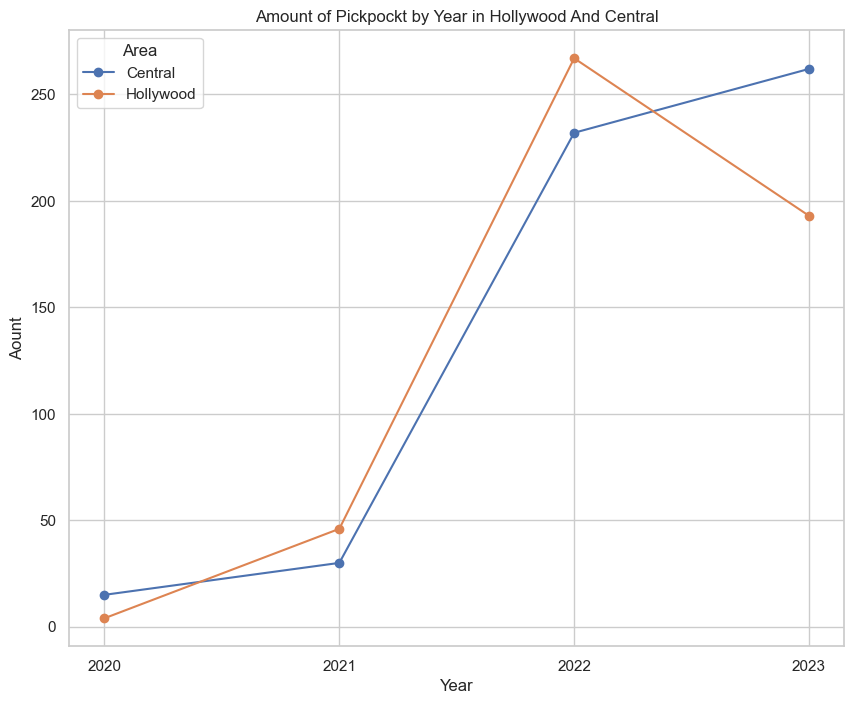

In [294]:
grouped_df= CentralANDHollywood_df.groupby(['area_name', 'year_occurred']).size().reset_index(name='count')

plt.figure(figsize=(10,8))


for area in grouped_df['area_name'].unique():
    area_data = grouped_df[grouped_df['area_name'] == area]
    plt.plot(area_data['year_occurred'], area_data['count'], marker='o', label=area)


plt.xlabel('Year')
plt.ylabel('Aount')
plt.title('Amount of Pickpockt by Year in Hollywood And Central')
plt.xticks(grouped_df['year_occurred'].unique())  
plt.legend(title='Area')


plt.grid(True)
plt.show()

### There has been a notable rise in pickpocketing incidents in both areas between 2020 and 2022. However, it appears that there was a decrease in Hollywood from 2022 to 2023, whereas Central saw an increase during the same period

In [295]:
status_description_counts = CentralANDHollywood_df["status_description"].value_counts().reset_index()
status_description_counts.columns = ['status_description', 'count']


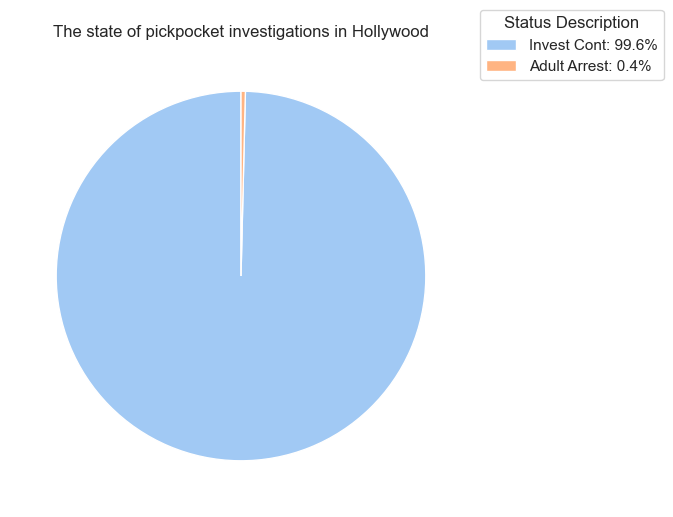

In [296]:
status_description_counts['percentage'] = (status_description_counts['count'] / status_description_counts['count'].sum()) * 100

# יצירת גרף הפאי ללא אחוזים על הדיאגרמה עצמה
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts = ax.pie(status_description_counts['percentage'], startangle=90, colors=sns.color_palette("pastel"))

# הוספת אגדה (legend) עם תוויות והאחוזים
legend_labels = [f'{desc}: {pct:.1f}%' for desc, pct in zip(status_description_counts['status_description'], status_description_counts['percentage'])]
ax.legend(wedges, legend_labels, title="Status Description", loc="center left", bbox_to_anchor=(1, 0.5, 0.5, 1))

# כותרת
ax.set_title('The state of pickpocket investigations in Hollywood')

# הצגת הגרף
plt.show()

<div style="
    text-align: left;
    font-size: 32px;
    font-weight: bold;
    color: #000000;
    text-shadow: 2px 2px 5px #888888;
    margin-top: 20px;
    margin-bottom: 20px;
    font-family: Arial, sans-serif;">
    Fourth Conclusion
</div>


## The central entertainment venues in Los Angeles experience the highest number of pickpocketing crimes, especially on weekends and at night, and the police do not address these cases.



<div style="text-align:center;">
    <img src="https://i.pinimg.com/originals/0a/29/48/0a29484ef88884987662b03d462a2178.jpg" alt="תיאור התמונה" style="width: 40%;">
</div>